# Import and misc

In [1]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses
import os
import io

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
import torchvision.transforms as T
import PIL
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils import prune

import torchaudio
from IPython import display as display_

import wandb

import matplotlib.pyplot as plt
from matplotlib import patches as plt_patch
import seaborn as sns

sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format='retina'

torchaudio.set_audio_backend('sox_io')

In [2]:
# fix random seeds for reproducibility
def set_seed(SEED=1234):
  torch.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(SEED)

set_seed(1234)

# Task

In this notebook we will implement a CRNN for finding a keyword in a stream.

In [3]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    n_fft: int = 400
    win_length: int = 400
    hop_length: int = 160
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 32
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [4]:
if not pathlib.Path('data/speech_commands').exists():
    !wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
    !mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log
    
    os.makedirs("data", exist_ok=True)
    !mv speech_commands/ data/

In [5]:
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keyword': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [6]:
dataset = SpeechCommandDataset(
    path2dir='data/speech_commands', keywords=TaskConfig.keyword
)

In [7]:
dataset.csv.sample(5)

path keyword  label
6001   data/speech_commands/eight/66cff190_nohash_0.wav   eight      0
48263   data/speech_commands/stop/9886d8bf_nohash_3.wav    stop      0
4336   data/speech_commands/eight/ab7b5acd_nohash_0.wav   eight      0
17206     data/speech_commands/on/d9b50b8b_nohash_0.wav      on      0
61523   data/speech_commands/bird/7b2e879e_nohash_1.wav    bird      0

### Augmentations

In [8]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'data/speech_commands/_background_noise_/white_noise.wav',
            'data/speech_commands/_background_noise_/dude_miaowing.wav',
            'data/speech_commands/_background_noise_/doing_the_dishes.wav',
            'data/speech_commands/_background_noise_/exercise_bike.wav',
            'data/speech_commands/_background_noise_/pink_noise.wav',
            'data/speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [9]:
indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [10]:
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [11]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [12]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [13]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [14]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [15]:
class LogMelspec(nn.Module):

    def __init__(self, is_train, config):
        super().__init__()
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=config.n_fft,
                    win_length=config.win_length,
                    hop_length=config.hop_length,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            )

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=config.n_fft,
                win_length=config.win_length,
                hop_length=config.hop_length,
                n_mels=config.n_mels
            )

    def forward(self, batch):
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [16]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

melspec_train.to(TaskConfig.device)
melspec_val.to(TaskConfig.device)

LogMelspec(
  (melspec): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
)

### Quality measurment functions:

In [17]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [18]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model

In [19]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        d = 2 if config.bidirectional else 1
        self.attention = Attention(config.hidden_size * d)
        self.classifier = nn.Linear(config.hidden_size * d, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)

In [20]:
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    mean_acc = 0
    mean_loss = 0
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)
        
        wandb.log({
            'train_step_loss': loss.item()
        }, step=i)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)
        
        wandb.log({
            'train_step_FA': FA,
            'train_step_FR': FR,
            'train_step_acc': acc.item()
        }, step=i)
        
        mean_acc += acc
        mean_loss += loss.item()

    return mean_acc / (i + 1), mean_loss / (i + 1)

In [21]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)
        
        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        
        wandb.log({
            "val_step_loss": loss.item(),
        }, step=i)
        
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        wandb.log({
            "val_step_FA": FA,
            "val_step_FR": FR,
            "val_step_acc": accs[-1]
        }, step=i)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr, sum(accs) / len(accs)

In [22]:
from collections import defaultdict
from IPython.display import clear_output

history = defaultdict(list)

In [23]:
config = TaskConfig(hidden_size=32)

# Training

In [61]:
config = TaskConfig(hidden_size=32)
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)


In [24]:
sum([p.numel() for p in model.parameters()])

25387

In [25]:
def train():
    for n in range(TaskConfig.num_epochs):

        mean_acc, mean_loss = train_epoch(model, opt, train_loader,
                                          melspec_train, config.device)

        au_fa_fr, mean_val_acc = validation(model, val_loader,
                                            melspec_val, config.device)

        wandb.log({
            "train_mean_acc": mean_acc.item(),
            "train_mean_loss": mean_loss,
            "val_au_fa_fr": au_fa_fr,
            "val_mean_acc": mean_val_acc 
        })

        clear_output()

        print('END OF EPOCH', n)

In [44]:
with wandb.init(project='KWS_SPEED_UP', name='Original KWS'):
    train()

# Full Model

In [37]:
class ModelWithMel(nn.Module):
    def __init__(self, m, spec):
        super().__init__()
        self.m = m
        self.spec = spec
    
    def forward(self, x):
        x = self.spec(x)
        return self.m(x)

In [25]:
original_model = ModelWithMel(model, melspec_val)
# torch.save(original_model, 'saved/torch/original/kws.pth')

# Speed Up

At first, let's define some useful functions

In [38]:
def get_model_from_torchscript(path, qat=False):
    """
    Convert back from torchscript to pytorch
    """
    config = TaskConfig(hidden_size=32)
    original_model = torch.jit.load(path, map_location=config.device)
    original_model_state_dict = original_model.state_dict()
    if qat: 
        model = QuantCRNN(config).to(config.device)
    else:
        model = CRNN(config).to(config.device)
    melspec_val = LogMelspec(is_train=False, config=config)
    melspec_val.to(config.device)
    original_model = ModelWithMel(model, melspec_val)
    original_model.load_state_dict(original_model_state_dict)
    
    return original_model

In [39]:
def get_qat_from_state_dict(path):
    """
    Loading Model with qat from state_dict
    
    PyTorch save function does not support afterwards loading.
    Make Sure QuatConv Class is defined before running this function.
    """
    config = TaskConfig(hidden_size=32, device='cpu')
    state_dict = torch.load(path)
    model = CRNN(config)

    new_conv = nn.Sequential(
        QuantConv(config),
        nn.Flatten(start_dim=1, end_dim=2)
    )

    new_conv.to(config.device)

    setattr(model, "conv", new_conv)

    model.eval()

    model.conv.qconfig = torch.quantization.get_default_qat_qconfig('qnnpack')
    model_prepared = torch.quantization.prepare_qat(model.train())
    model_prepared.gru.flatten_parameters()
    
    model_prepared.gru.flatten_parameters()
    model_prepared.eval()
    model_int8 = torch.quantization.convert(model_prepared)
    model_int8.gru.flatten_parameters()
        
    # Fix for state dict was found here:
    # https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113/3
    model_dict = model_int8.state_dict()
    # 1. filter out unnecessary keys
    state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
    # 2. overwrite entries in the existing state dict
    model_dict.update(state_dict) 
    # 3. load the new state dict
    model_int8.load_state_dict(model_dict)
    
    melspec_val.to(config.device)
    return ModelWithMel(model_int8, melspec_val)

In [40]:
import tempfile
from thop import profile

def get_size_in_megabytes(full_model):
    # https://pytorch.org/tutorials/recipes/recipes/dynamic_quantization.html#look-at-model-size
    model = full_model.m
    with tempfile.TemporaryFile() as f:
        torch.save(model.state_dict(), f)
        size = f.tell() / 2**20
    return size
  
def get_weights_and_flops(model):
    input_wav = torch.randn(config.sample_rate * 2).to(config.device)
    input_wav = input_wav[None, None, :]
    input_spec = model.spec(input_wav)
    return profile(model.m, input_spec)

In [41]:
@torch.no_grad()
def evaluation(model, loader, device):
    model.eval()
    
    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        
#         wandb.log({
#             "val_step_loss": loss.item(),
#         }, step=i)
        
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
#         wandb.log({
#             "val_step_FA": FA,
#             "val_step_FR": FR,
#             "val_step_acc": accs[-1]
#         }, step=i)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr, sum(accs) / len(accs)

In [42]:
original_path = 'saved/torch/original/kws.pth'
original_model = torch.load(original_path, map_location=config.device)
get_size_in_megabytes(original_model)

0.09998607635498047

In [31]:
evaluation(original_model, val_loader, config.device)

102it [00:04, 20.69it/s]


(3.836536339903156e-05, 0.9676371467704729)

## Unstructured Pruning

based on https://pytorch.org/tutorials/intermediate/pruning_tutorial.html#pruning-multiple-parameters-in-a-model

In [35]:
def get_parameters_to_prune(model):
    parameters_to_prune = []
    for name, _ in model.m.gru.named_parameters():
        if "weight" in name:
            parameters_to_prune.append((model.m.gru, name))
    parameters_to_prune.append((getattr(model.m.conv, "0"), "weight"))
    parameters_to_prune.append((getattr(model.m.attention.energy, "0"), "weight"))
    parameters_to_prune.append((getattr(model.m.attention.energy, "2"), "weight"))
    parameters_to_prune.append((model.m.classifier, "weight"))
    return parameters_to_prune

In [36]:
pruned_model = torch.load(original_path)
parameters_to_prune = get_parameters_to_prune(pruned_model)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.22,
)

pruned_model.m.gru.flatten_parameters()

# remove hooks to prevent extra computational costs
for layer, name in parameters_to_prune:
    prune.remove(layer, name)

pruned_model.m.gru.flatten_parameters()

In [37]:
#list(pruned_model.named_parameters())

In [37]:
torch.save(pruned_model, 'saved/torch/speed_up/pruned_unstructured_kws.pth')

In [39]:
pruned_model = torch.load('saved/torch/speed_up/pruned_unstructured_kws.pth',
                          map_location=config.device)
evaluation(pruned_model, val_loader, config.device)

102it [00:02, 38.88it/s]


(3.599027946174511e-05, 0.9675605536332179)

In [40]:
orig_size = get_size_in_megabytes(original_model)
pruned_size = get_size_in_megabytes(pruned_model)

pruned_sparse_model = torch.load('saved/torch/speed_up/pruned_unstructured_kws.pth',
                                 map_location=config.device)
parameters_to_prune = get_parameters_to_prune(pruned_sparse_model)
# convert pruned matrices to sparse
for layer, name in parameters_to_prune:
    new_value = nn.Parameter(getattr(layer, name).to_sparse())
    setattr(layer, name, new_value)
pruned_sparse_size = get_size_in_megabytes(pruned_sparse_model)

print(f'Original: {round(orig_size, 6)}, Pruned: {round(pruned_size, 6)},',
      f'Sparse Pruned: {round(pruned_sparse_size, 6)}')

Original: 0.132999, Pruned: 0.13306, Sparse Pruned: 0.50766


## Structured Pruning

In [33]:
def prune_solo_gru_layer(model, amount=0.4, index='0'):
    # Conv Layer
    module = model.m.gru
    prune.ln_structured(module, name='weight_ih_l0', n=2, amount=amount, dim=0)
    prune.remove(module, name='weight_ih_l0')
    prune.ln_structured(module, name='weight_hh_l0', n=2, amount=amount, dim=0)
    prune.remove(module, name='weight_hh_l0')
        
    nonzero_features = torch.sum(torch.absolute(module.weight_ih_l0), dim=[1]) != 0
    
    while nonzero_features.sum() % 3 != 0:
        nonzero_features[torch.randint(low=0, high=nonzero_features.shape[0], size=(1,))] = False
    assert nonzero_features.sum() % 3 == 0
    
    new_gru = nn.GRU(input_size=module.input_size, hidden_size=nonzero_features.sum() // 3,
                     batch_first=module.batch_first)
    new_gru.bias_ih_l0 = nn.Parameter(module.bias_ih_l0[nonzero_features])
    new_gru.weight_ih_l0 = nn.Parameter(module.weight_ih_l0[nonzero_features, :])
    
    nonzero_features = torch.sum(torch.absolute(module.weight_hh_l0), dim=[1]) != 0
    while nonzero_features.sum() % 3 != 0:
        nonzero_features[torch.randint(low=0, high=nonzero_features.shape[0], size=(1,))] = False
    
    new_hidden_size = nonzero_features.sum() // 3
    old_size = module.weight_hh_l0.shape[1]
    amount = float(1 - new_hidden_size / old_size)
    prune.ln_structured(module, name='weight_hh_l0', n=2, amount=amount, dim=1)
    prune.remove(module, name='weight_hh_l0')
    
    hidden_features = torch.sum(torch.absolute(module.weight_hh_l0), dim=[0]) != 0
            
    new_gru.bias_hh_l0 = nn.Parameter(module.bias_hh_l0[nonzero_features])
    new_gru.weight_hh_l0 = nn.Parameter(
                  module.weight_hh_l0[nonzero_features, :][:, hidden_features]
    )
    
    model.m.gru = new_gru
    
    # Fix attention hidden_size
    
    module = getattr(model.m.attention.energy, "0")

    new_linear = nn.Linear(in_features=hidden_features.sum(),
                           out_features=module.out_features)
    new_linear.bias = nn.Parameter(module.bias)
    new_linear.weight = nn.Parameter(module.weight[:, hidden_features])

    setattr(model.m.attention.energy, "0", new_linear)

    # Fix Classifier
    
    module = model.m.classifier

    new_linear = nn.Linear(in_features=hidden_features.sum(),
                           out_features=module.out_features)
    new_linear.bias = nn.Parameter(module.bias)
    new_linear.weight = nn.Parameter(module.weight[:, hidden_features])

    model.m.classifier = new_linear

In [34]:
def prune_input_gru_layer(model, amount=0.4, index='0'):
    module = model.m.gru
    prune.ln_structured(module, name='weight_ih_l0', n=2, amount=amount, dim=1)
    prune.remove(module, name='weight_ih_l0')
        
    nonzero_features = torch.sum(torch.absolute(module.weight_ih_l0), dim=[0]) != 0

    new_gru = nn.GRU(input_size=nonzero_features.sum(), 
                     hidden_size=module.hidden_size,
                     batch_first=module.batch_first)
    new_gru.bias_ih_l0 = nn.Parameter(module.bias_ih_l0)
    new_gru.weight_ih_l0 = nn.Parameter(module.weight_ih_l0[:, nonzero_features])
            
    new_gru.bias_hh_l0 = nn.Parameter(module.bias_hh_l0)
    new_gru.weight_hh_l0 = nn.Parameter(module.weight_hh_l0)
    
    model.m.gru = new_gru
    
    return nonzero_features

In [35]:
def prune_conv_layer(model, amount=0.4, index='0'):
    # Conv Layer
    module = getattr(model.m.conv, index)
    prune.ln_structured(module, name='weight', n=2, amount=amount, dim=0)
    prune.remove(module, name='weight')

    nonzero_channels = torch.sum(torch.absolute(module.weight), dim=[1, 2, 3]) != 0
    new_conv = nn.Conv2d(in_channels=module.in_channels,
                         out_channels=nonzero_channels.sum(),
                         kernel_size=module.kernel_size,
                         stride=module.stride,
                         dilation=module.dilation)
    new_conv.bias = nn.Parameter(module.bias[nonzero_channels])
    new_conv.weight = nn.Parameter(module.weight[nonzero_channels, :])

    setattr(model.m.conv, index, new_conv)

    # Fix GRU input_size

    conv_out_frequency = model.m.gru.input_size // nonzero_channels.shape[0]
    new_gru = nn.GRU(
        input_size= conv_out_frequency * nonzero_channels.sum(),
        hidden_size=model.m.gru.hidden_size,
        num_layers=model.m.gru.num_layers,
        dropout=model.m.gru.dropout,
        bidirectional=model.m.gru.bidirectional,
        batch_first=model.m.gru.batch_first
    )

    for name, _ in model.m.gru.named_parameters():
        if name != 'weight_ih_l0':
            setattr(new_gru, name, getattr(model.m.gru, name))
        else:
            old_weight = getattr(model.m.gru, name)
            new_indecies = []
            for i in range(nonzero_channels.shape[0]):
                if nonzero_channels[i]:
                    indecies = np.arange(conv_out_frequency)
                    indecies += i * conv_out_frequency
                    new_indecies.extend(indecies.tolist())
            new_weight = nn.Parameter(old_weight[:, new_indecies])
            setattr(new_gru, name, new_weight)

    model.m.gru = new_gru
    
    model.m.gru.flatten_parameters()

In [36]:
original_model.m.attention

Attention(
  (energy): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [37]:
def prune_attention_layer(model, amount=0.4):
    # Conv Layer
    module = getattr(model.m.attention.energy, "0")
    prune.ln_structured(module, name='weight', n=2, amount=amount, dim=0)
    prune.remove(module, name='weight')

    nonzero_rows = torch.sum(torch.absolute(module.weight), dim=[1]) != 0
    new_linear = nn.Linear(in_features=module.in_features,
                           out_features=nonzero_rows.sum())
    new_linear.bias = nn.Parameter(module.bias[nonzero_rows])
    new_linear.weight = nn.Parameter(module.weight[nonzero_rows, :])

    setattr(model.m.attention.energy, "0", new_linear)

    # Fix Second Linear
    module = getattr(model.m.attention.energy, "2")
    
    new_linear = nn.Linear(in_features=nonzero_rows.sum(),
                           out_features=module.out_features)
    new_linear.bias = module.bias
    new_linear.weight = nn.Parameter(module.weight[:, nonzero_rows])
    setattr(model.m.attention.energy, "2", new_linear)

In [38]:
pruned_model = torch.load(original_path, map_location=config.device)

prune_conv_layer(pruned_model, amount=0.4)
prune_attention_layer(pruned_model, amount=0.6)

In [39]:
#list(pruned_model.m.conv.named_parameters())
pruned_model.m.attention

Attention(
  (energy): Sequential(
    (0): Linear(in_features=32, out_features=13, bias=True)
    (1): Tanh()
    (2): Linear(in_features=13, out_features=1, bias=True)
  )
)

In [40]:
get_size_in_megabytes(pruned_model), get_size_in_megabytes(original_model)

(0.12952327728271484, 0.09998607635498047)

In [41]:
get_weights_and_flops(pruned_model), get_weights_and_flops(original_model)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


((646755.0, 19254.0), (904608.0, 25387.0))

In [107]:
evaluation(pruned_model, val_loader, config.device)

102it [00:02, 37.09it/s]


(5.3725830872838865e-05, 0.9544270833333334)

In [108]:
torch.save(pruned_model, 'saved/torch/speed_up/pruned_structured_kws.pth')

## Dynamic Quantization

In [112]:
model = torch.load(original_path, map_location='cpu')
quantized_model = torch.quantization.quantize_dynamic(
    model, {nn.GRU, nn.Linear}, dtype=torch.qint8
)

In [113]:
get_size_in_megabytes(original_model) / get_size_in_megabytes(quantized_model)

1.9989014858108585

In [117]:
quantized_model.to('cpu')
evaluation(quantized_model, val_loader, 'cpu')

102it [00:03, 31.86it/s]


(3.9564840462837024e-05, 0.9671775879469434)

In [118]:
torch.save(quantized_model, 'saved/torch/speed_up/quantized_kws.pth')

## QAT Conv

In [24]:
class QuantConv(nn.Module):
    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config
        self.quant = torch.quantization.QuantStub()
        self.conv = nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
        )       
        self.dequant = torch.quantization.DeQuantStub()
        
    def forward(self, x):
        x = self.quant(x)
        x = self.conv(x)
        x = self.dequant(x)
        return x

In [216]:
set_seed(12)
config.device = 'cpu'

model = CRNN(config)

new_conv = nn.Sequential(
    QuantConv(config),
    nn.Flatten(start_dim=1, end_dim=2)
)

new_conv.to(config.device)

setattr(model, "conv", new_conv)

In [217]:
model

CRNN(
  (conv): Sequential(
    (0): QuantConv(
      (quant): QuantStub()
      (conv): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
      (dequant): DeQuantStub()
    )
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)

In [218]:
melspec_train.to(config.device)
melspec_val.to(config.device)

model.to(config.device)

model.eval()

model.conv.qconfig = torch.quantization.get_default_qat_qconfig('qnnpack')
model_prepared = torch.quantization.prepare_qat(model.train())
model_prepared.gru.flatten_parameters()

opt = torch.optim.Adam(
    model_prepared.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

In [219]:
def qatrain(model, device):
    for n in range(TaskConfig.num_epochs):

        mean_acc, mean_loss = train_epoch(model, opt, train_loader,
                                          melspec_train, device)
      
      
        quantized_model = torch.ao.quantization.convert(model.eval(), inplace=False)
        quantized_model.eval()
        au_fa_fr, mean_val_acc = validation(quantized_model, val_loader,
                                            melspec_val, device)

        wandb.log({
            "train_mean_acc": mean_acc.item(),
            "train_mean_loss": mean_loss,
            "val_au_fa_fr": au_fa_fr,
            "val_mean_acc": mean_val_acc 
        })

        clear_output()

        print('END OF EPOCH', n)

In [43]:
with wandb.init(project='KWS_SPEED_UP', name='QAT KWS'):
    qatrain(model_prepared, config.device)

In [221]:
model_prepared.gru.flatten_parameters()
model_prepared.eval()
model_int8 = torch.quantization.convert(model_prepared)
model_int8.gru.flatten_parameters()

In [222]:
qat_model = ModelWithMel(model_int8, melspec_val)

In [223]:
qat_model

ModelWithMel(
  (m): CRNN(
    (conv): Sequential(
      (0): QuantConv(
        (quant): Quantize(scale=tensor([0.1153]), zero_point=tensor([180]), dtype=torch.quint8)
        (conv): QuantizedConv2d(1, 8, kernel_size=(5, 20), stride=(2, 8), scale=0.32216504216194153, zero_point=123)
        (dequant): DeQuantize()
      )
      (1): Flatten(start_dim=1, end_dim=2)
    )
    (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
    (attention): Attention(
      (energy): Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
        (1): Tanh()
        (2): Linear(in_features=32, out_features=1, bias=True)
      )
    )
    (classifier): Linear(in_features=32, out_features=2, bias=True)
  )
  (spec): LogMelspec(
    (melspec): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
)

In [224]:
get_size_in_megabytes(qat_model)

0.13327312469482422

In [271]:
torch.save(qat_model.m.state_dict(), 'saved/torch/speed_up/qat_kws.pth') 
# state_dict instead of model to enable loading

In [34]:
evaluation(qat_model, val_loader, config.device)

In [278]:
get_weights_and_flops(qat_model)

[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


(274272.0, 24579.0)

In [56]:
qat_model = get_qat_from_state_dict('saved/torch/speed_up/qat_kws.pth')

In [49]:
# evaluation(qat_model, val_loader, config.device)

## Dynamic + QAT Quantization

In [47]:
config.device = 'cpu'
qat_model = get_qat_from_state_dict('saved/torch/speed_up/qat_kws.pth')
quantized_model = torch.quantization.quantize_dynamic(
    qat_model, {nn.GRU, nn.Linear}, dtype=torch.qint8
)

In [48]:
quantized_model

ModelWithMel(
  (m): CRNN(
    (conv): Sequential(
      (0): QuantConv(
        (quant): Quantize(scale=tensor([0.1153]), zero_point=tensor([180]), dtype=torch.quint8)
        (conv): QuantizedConv2d(1, 8, kernel_size=(5, 20), stride=(2, 8), scale=0.32216504216194153, zero_point=123)
        (dequant): DeQuantize()
      )
      (1): Flatten(start_dim=1, end_dim=2)
    )
    (gru): DynamicQuantizedGRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
    (attention): Attention(
      (energy): Sequential(
        (0): DynamicQuantizedLinear(in_features=32, out_features=32, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
        (1): Tanh()
        (2): DynamicQuantizedLinear(in_features=32, out_features=1, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
      )
    )
    (classifier): DynamicQuantizedLinear(in_features=32, out_features=2, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  )
  (spec): LogMelspec(
    (melspec): MelSpectrogram(
      (spectrogram): Spectr

In [2238]:
get_size_in_megabytes(quantized_model)

0.033957481384277344

In [2239]:
get_weights_and_flops(quantized_model)

[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.


(0.0, 0)

In [2235]:
evaluation(quantized_model, val_loader, config.device)

102it [00:03, 31.94it/s]


(2.082077351053369e-05, 0.9653033088235294)

In [74]:
#torch.jit.save(torch.jit.script(quantized_model), 'saved/jit/speed_up/super_quant_kws.pth')

## Distillation

In [49]:
def distil_train_epoch(model, teacher, temperature, distil_weight,
                       opt, scheduler, loader, log_melspec, distil_log_melspec,
                       device):
    model.train()
    teacher.eval()
    mean_acc = 0
    mean_loss = 0
    mean_distil_loss = 0
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        teacher_batch = log_melspec(batch)
        batch = distil_log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.log_softmax(logits / temperature, dim=-1)
        
        
        with torch.no_grad():
            teacher_logits = teacher(teacher_batch)
            teacher_probs = F.softmax(teacher_logits / temperature, dim=-1)
            
        task_loss = F.cross_entropy(logits, labels) 
        
        distil_loss = F.kl_div(probs, teacher_probs, reduction='batchmean')
        
        loss = (task_loss + distil_weight * distil_loss) / (1 + distil_weight)
        
        wandb.log({
            'train_step_loss': task_loss.item(),
            'train_step_distil_loss': distil_loss.item()
        }, step=i)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()
        scheduler.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)
        
        wandb.log({
            'train_step_FA': FA,
            'train_step_FR': FR,
            'train_step_acc': acc.item(),
            'lr': scheduler.get_last_lr()[0]
        }, step=i)
        
        mean_acc += acc
        mean_loss += task_loss.item()
        mean_distil_loss += distil_loss.item()

    return mean_acc / (i + 1), mean_loss / (i + 1), mean_distil_loss / (i + 1)

In [50]:
config = TaskConfig(hidden_size=16, gru_num_layers=1,
                    device='cpu')

teacher = quantized_model.m
temperature = 100
distil_weight = 20

set_seed(1)

model = CRNN(config)
opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)
scheduler = torch.optim.lr_scheduler.StepLR(opt, 
                                            step_size=25 * len(train_loader),
                                            gamma=0.1)

model.to(config.device)
teacher.to(config.device)

distil_melspec_train = LogMelspec(is_train=True, config=config)
distil_melspec_val = LogMelspec(is_train=False, config=config)

distil_melspec_train.to(config.device)
distil_melspec_val.to(config.device)

melspec_train.to(config.device)
melspec_val.to(config.device)

LogMelspec(
  (melspec): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
)

In [51]:
get_weights_and_flops(ModelWithMel(model, distil_melspec_val))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


(518912.0, 8907.0)

In [52]:
get_size_in_megabytes(ModelWithMel(model, distil_melspec_val))

0.039528846740722656

In [742]:
def distil_train(model, teacher, temperature, distil_weight, num_epochs):
    for n in range(num_epochs):

        mean_acc, mean_loss, mean_distil_loss = distil_train_epoch(model,
                                                     teacher, temperature,
                                                     distil_weight,
                                                     opt, scheduler, train_loader,
                                                     melspec_train,
                                                     distil_melspec_train, config.device)

        au_fa_fr, mean_val_acc = validation(model, val_loader,
                                            distil_melspec_val, config.device)

        wandb.log({
            "train_mean_acc": mean_acc.item(),
            "train_mean_loss": mean_loss,
            "train_mean_distil_loss": mean_distil_loss,
            "val_au_fa_fr": au_fa_fr,
            "val_mean_acc": mean_val_acc 
        })

        clear_output()

        print('END OF EPOCH', n)

In [53]:
with wandb.init(project='KWS_SPEED_UP', name='Distil KWS 2',
                config=dataclasses.asdict(config)):
    wandb.config.update({'temperature': temperature, 
                         'distil_weight': distil_weight})
    distil_train(model, teacher, temperature, distil_weight, 35)

In [505]:
distil_model = ModelWithMel(model, distil_melspec_val)
#torch.save(distil_model, 'saved/torch/speed_up/distil_kws.pth')

In [508]:
distil_model = torch.load('saved/torch/speed_up/distil_kws.pth')
evaluation(distil_model, val_loader, config.device)

102it [00:03, 30.00it/s]


(4.392115019705588e-05, 0.9466145833333334)

In [554]:
get_size_in_megabytes(original_model)

0.09998607635498047

## Layer-wise Distillation

In [55]:
def student_layer_distil_train_epoch(model, teacher, temperature, distil_weight, 
                                     layer_distil_weight, opt, scheduler, loader,
                                     log_melspec, distil_log_melspec, conv_layer,
                                     gru_layer, attention_layer, loss_type, device):
    model.train()
    teacher.eval()
    mean_acc = 0
    mean_loss = 0
    mean_distil_loss = 0
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        teacher_batch = log_melspec(batch)
        batch = distil_log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        input = batch.unsqueeze(dim=1)
        conv_output = model.conv(input).transpose(-1, -2)
                
        gru_output, _ = model.gru(conv_output)
        contex_vector = model.attention(gru_output)
        logits = model.classifier(contex_vector)
        
        # we need probabilities so we use softmax & CE separately
        probs = F.log_softmax(logits / temperature, dim=-1)
        
        
        with torch.no_grad():
            input = teacher_batch.unsqueeze(dim=1)
            teacher_conv_output = teacher.conv(input).transpose(-1, -2)
            teacher_gru_output, _ = teacher.gru(teacher_conv_output)
            teacher_contex_vector = teacher.attention(teacher_gru_output)
            teacher_logits = teacher.classifier(teacher_contex_vector)
            teacher_probs = F.softmax(teacher_logits / temperature, dim=-1)
            
        conv_output = conv_layer(conv_output)
        gru_output = gru_layer(gru_output)
        contex_vector = attention_layer(contex_vector)
            
        conv_output = torch.flatten(conv_output, start_dim=1)
        conv_probs = F.log_softmax(conv_output / temperature, dim=-1)
        teacher_conv_output = torch.flatten(teacher_conv_output, start_dim=1)
        teacher_conv_probs = F.softmax(teacher_conv_output / temperature, dim=-1)
        
        gru_output = torch.flatten(gru_output, start_dim=1)
        gru_probs = F.log_softmax(gru_output / temperature, dim=-1)
        teacher_gru_output = torch.flatten(teacher_gru_output, start_dim=1)
        teacher_gru_probs = F.softmax(teacher_gru_output / temperature, dim=-1)
        
        contex_vector = torch.flatten(contex_vector, start_dim=1)
        contex_probs = F.log_softmax(contex_vector / temperature, dim=-1)
        teacher_contex_vector = torch.flatten(teacher_contex_vector, start_dim=1)
        teacher_contex_probs = F.softmax(teacher_contex_vector / temperature, dim=-1)
                    
        task_loss = F.cross_entropy(logits, labels) 
        
        distil_loss = F.kl_div(probs, teacher_probs, reduction='batchmean')
        
        if loss_type == 'kl':
            distil_loss = distil_loss + layer_distil_weight * F.kl_div(conv_probs, 
                                                 teacher_conv_probs, 
                                                 reduction='batchmean')
            distil_loss = distil_loss + layer_distil_weight * F.kl_div(gru_probs, 
                                                 teacher_gru_probs, 
                                                 reduction='batchmean')
            distil_loss = distil_loss + layer_distil_weight * F.kl_div(contex_probs, 
                                                 teacher_contex_probs, 
                                                 reduction='batchmean')
        else:
            distil_loss = distil_loss + layer_distil_weight * F.mse_loss(logits,
                                                                         teacher_logits)
            distil_loss = distil_loss + layer_distil_weight * F.mse_loss(conv_output, 
                                                   teacher_conv_output)
            distil_loss = distil_loss + layer_distil_weight * F.mse_loss(gru_output, 
                                                   teacher_gru_output)
            distil_loss = distil_loss + layer_distil_weight * F.mse_loss(contex_vector, 
                                                   teacher_contex_vector)
        
        loss = (task_loss + distil_weight * distil_loss) / (1 + distil_weight)
        
        wandb.log({
            'train_step_loss': task_loss.item(),
            'train_step_distil_loss': distil_loss.item()
        }, step=i)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()
        scheduler.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)
        
        wandb.log({
            'train_step_FA': FA,
            'train_step_FR': FR,
            'train_step_acc': acc.item(),
            'lr': scheduler.get_last_lr()[0]
        }, step=i)
        
        mean_acc += acc
        mean_loss += task_loss.item()
        mean_distil_loss += distil_loss.item()

    return mean_acc / (i + 1), mean_loss / (i + 1), mean_distil_loss / (i + 1)

In [60]:
def student_layer_distil_train(model, teacher, temperature, distil_weight,
                       layer_distil_weight, loss_type, num_epochs):
    for n in range(num_epochs):
        conv_layer.train()
        gru_layer.train()
        attention_layer.train()
        
        mean_acc, mean_loss, mean_distil_loss = student_layer_distil_train_epoch(
                                                     model,
                                                     teacher, temperature,
                                                     distil_weight,
                                                     layer_distil_weight,
                                                     opt, scheduler, train_loader,
                                                     melspec_train,
                                                     distil_melspec_train,
                                                     conv_layer,
                                                     gru_layer,
                                                     attention_layer,
                                                     loss_type,
                                                     config.device)

        au_fa_fr, mean_val_acc = validation(model, val_loader,
                                            distil_melspec_val, config.device)

        wandb.log({
            "train_mean_acc": mean_acc.item(),
            "train_mean_loss": mean_loss,
            "train_mean_distil_loss": mean_distil_loss,
            "val_au_fa_fr": au_fa_fr,
            "val_mean_acc": mean_val_acc 
        })

        clear_output()

        print('END OF EPOCH', n)

In [57]:
config = TaskConfig(hidden_size=16, gru_num_layers=1, n_mels=30,
                    cnn_out_channels=4,
                    device='cpu')

teacher = quantized_model.m
temperature = 100
distil_weight = 20
layer_distil_weight = 1e-5

set_seed(1)

model = CRNN(config)

conv_layer = nn.Linear(model.gru.input_size,
                               teacher.gru.input_size)
        
student_d = (int(model.gru.bidirectional) + 1)
teacher_d = (int(teacher.gru.bidirectional) + 1)
        
gru_layer = nn.Linear(model.gru.hidden_size * student_d,
                              teacher.gru.hidden_size * teacher_d)
attention_layer = nn.Linear(model.gru.hidden_size * student_d,
                                    teacher.gru.hidden_size * teacher_d)

params = list(model.parameters())

# uncomment the following line to use learnable layer-wise projection

# params = list(model.parameters()) + list(conv_layer.parameters()) \
#          + list(gru_layer.parameters()) + list(attention_layer.parameters())

opt = torch.optim.Adam(
    params,
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)
scheduler = torch.optim.lr_scheduler.StepLR(opt, 
                                            step_size=45 * len(train_loader),
                                            gamma=0.1)

model.to(config.device)
teacher.to(config.device)

distil_melspec_train = LogMelspec(is_train=True, config=config)
distil_melspec_val = LogMelspec(is_train=False, config=config)

distil_melspec_train.to(config.device)
distil_melspec_val.to(config.device)

melspec_train.to(config.device)
melspec_val.to(config.device)

LogMelspec(
  (melspec): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
)

In [58]:
get_weights_and_flops(ModelWithMel(model, distil_melspec_val))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


(205744.0, 4087.0)

In [62]:
with wandb.init(project='KWS_SPEED_UP', name='Layer Distil KWS 2',
                config=dataclasses.asdict(config)):
    wandb.config.update({'temperature': temperature, 
                         'distil_weight': distil_weight,
                         'layer_distil_weight': layer_distil_weight})
    student_layer_distil_train(model, teacher, temperature, 
                               distil_weight, layer_distil_weight,
                               'mse', 60)

In [976]:
distil_model = ModelWithMel(model, distil_melspec_val)
torch.save(distil_model, 'saved/torch/speed_up/layer_distil_kws2.pth')

In [977]:
distil_model = torch.load('saved/torch/speed_up/layer_distil_kws2.pth')
evaluation(distil_model, val_loader, config.device)

102it [00:03, 29.17it/s]


(5.462693055758825e-05, 0.9590226715686274)

In [997]:
get_weights_and_flops(distil_model)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


(670744.0, 6118.0)

## DepthWise Separable Conv + Layer-Wise Distillation

Projections are changed from student-to-teacher to teacher-to-student version.

Pretrain functions are based on [TED](https://arxiv.org/abs/2210.01351) idea

In [1919]:
def layer_distil_pretrain_epoch(teacher, opt, loader,
                                log_melspec, conv_layer,
                                gru_layer, attention_layer, 
                                conv_head, gru_head, attention_head,
                                device):
    teacher.eval()
    mean_loss = 0

    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        teacher_batch = log_melspec(batch)

        opt.zero_grad()
        
        with torch.no_grad():
            input = teacher_batch.unsqueeze(dim=1)
            teacher_conv_output = teacher.conv(input).transpose(-1, -2)
            teacher_gru_output, _ = teacher.gru(teacher_conv_output)
            teacher_contex_vector = teacher.attention(teacher_gru_output)
            teacher_logits = teacher.classifier(teacher_contex_vector)
            teacher_probs = F.softmax(teacher_logits / temperature, dim=-1)
            
        teacher_conv_output = conv_layer(teacher_conv_output)
        teacher_conv_output = torch.flatten(teacher_conv_output, start_dim=1)
        teacher_gru_output = gru_layer(teacher_gru_output)
        teacher_gru_output = torch.flatten(teacher_gru_output, start_dim=1)
        teacher_contex_vector = attention_layer(teacher_contex_vector)
        teacher_contex_vector = torch.flatten(teacher_contex_vector, start_dim=1)

        
        conv_logits = conv_head(teacher_conv_output)
        gru_logits = gru_head(teacher_gru_output)
        contex_logits = attention_head(teacher_contex_vector)
            
                    
        task_loss = F.cross_entropy(conv_logits, labels) + \
                    F.cross_entropy(gru_logits, labels) + \
                    F.cross_entropy(contex_logits, labels)
        
        
        wandb.log({
            'train_step_loss': task_loss.item(),
        }, step=i)

        task_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        mean_loss += task_loss.item()

    return mean_loss / (i + 1)

In [1920]:
def layer_distil_pretrain(teacher, num_epochs):
    for n in range(num_epochs):
        conv_layer.train()
        gru_layer.train()
        attention_layer.train()
                        
        conv_head = nn.Sequential(
            nn.ReLU(),
            nn.Linear(conv_layer.out_features * 11, 2)
        )
        gru_head = nn.Sequential(
            nn.ReLU(),
            nn.Linear(gru_layer.out_features * 11, 2)
        )
        attention_head = nn.Sequential(
            nn.ReLU(),
            nn.Linear(attention_layer.out_features, 2)
        )
        
        params = list(conv_layer.parameters()) + list(gru_layer.parameters())
        params += list(attention_layer.parameters()) + list(conv_head.parameters())
        params += list(gru_head.parameters()) + list(attention_head.parameters())
        
        params = torch.optim.Adam(params, lr=3e-3)
        
        mean_loss = layer_distil_pretrain_epoch(teacher, opt, train_loader,
                                                     melspec_train,
                                                     conv_layer,
                                                     gru_layer,
                                                     attention_layer,
                                                     conv_head, gru_head,
                                                     attention_head,
                                                     config.device)

        wandb.log({
            "train_mean_loss": mean_loss,
        })

        clear_output()

        print('END OF EPOCH', n)

In [2012]:
def layer_distil_train_epoch(model, teacher, temperature, distil_weight, 
                             layer_distil_weight, opt, scheduler, loader,
                             log_melspec, distil_log_melspec, conv_layer,
                             gru_layer, attention_layer, loss_type, device):
    model.train()
    teacher.eval()
    mean_acc = 0
    mean_loss = 0
    mean_distil_loss = 0
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        teacher_batch = batch
        batch, labels = batch.to(device), labels.to(device)
        teacher_batch = log_melspec(teacher_batch)
        batch = distil_log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        input = batch.unsqueeze(dim=1)
        conv_output = model.conv(input).transpose(-1, -2)
                
        gru_output, _ = model.gru(conv_output)
        contex_vector = model.attention(gru_output)
        logits = model.classifier(contex_vector)
        
        # we need probabilities so we use softmax & CE separately
        probs = F.log_softmax(logits / temperature, dim=-1)
        
        
        with torch.no_grad():
            input = teacher_batch.unsqueeze(dim=1)
            teacher_conv_output = teacher.conv(input).transpose(-1, -2)
            teacher_gru_output, _ = teacher.gru(teacher_conv_output)
            teacher_contex_vector = teacher.attention(teacher_gru_output)
            teacher_logits = teacher.classifier(teacher_contex_vector)
            teacher_probs = F.softmax(teacher_logits / temperature, dim=-1)
            
        teacher_conv_output = teacher_conv_output.to(device)
        teacher_gru_output = teacher_gru_output.to(device)
        teacher_contex_vector = teacher_contex_vector.to(device)
        teacher_logits = teacher_logits.to(device)
        teacher_probs = teacher_probs.to(device)
            
        teacher_conv_output = conv_layer(teacher_conv_output)
        teacher_gru_output = gru_layer(teacher_gru_output)
        teacher_contex_vector = attention_layer(teacher_contex_vector)
                    
        conv_output = torch.flatten(conv_output, start_dim=1)
        conv_probs = F.log_softmax(conv_output / temperature, dim=-1)
        teacher_conv_output = torch.flatten(teacher_conv_output, start_dim=1)
        teacher_conv_probs = F.softmax(teacher_conv_output / temperature, dim=-1)
        
        
        gru_output = torch.flatten(gru_output, start_dim=1)
        gru_probs = F.log_softmax(gru_output / temperature, dim=-1)
        teacher_gru_output = torch.flatten(teacher_gru_output, start_dim=1)
        teacher_gru_probs = F.softmax(teacher_gru_output / temperature, dim=-1)
        
        contex_vector = torch.flatten(contex_vector, start_dim=1)
        contex_probs = F.log_softmax(contex_vector / temperature, dim=-1)
        teacher_contex_vector = torch.flatten(teacher_contex_vector, start_dim=1)
        teacher_contex_probs = F.softmax(teacher_contex_vector / temperature, dim=-1)
                    
        task_loss = F.cross_entropy(logits, labels) 
        
        distil_loss = F.kl_div(probs, teacher_probs, reduction='batchmean')
        
        if loss_type == 'kl':
            distil_loss = distil_loss + layer_distil_weight * F.kl_div(conv_probs, 
                                                 teacher_conv_probs, 
                                                 reduction='batchmean')
            distil_loss = distil_loss + layer_distil_weight * F.kl_div(gru_probs, 
                                                 teacher_gru_probs, 
                                                 reduction='batchmean')
            distil_loss = distil_loss + layer_distil_weight * F.kl_div(contex_probs, 
                                                 teacher_contex_probs, 
                                                 reduction='batchmean')
        else:
            distil_loss = distil_loss + layer_distil_weight * F.mse_loss(conv_output, 
                                                   teacher_conv_output)
            distil_loss = distil_loss + layer_distil_weight * F.mse_loss(gru_output, 
                                                   teacher_gru_output)
            distil_loss = distil_loss + layer_distil_weight * F.mse_loss(contex_vector, 
                                                   teacher_contex_vector)
        
        loss = (task_loss + distil_weight * distil_loss) / (1 + distil_weight)
        
        wandb.log({
            'train_step_loss': task_loss.item(),
            'train_step_distil_loss': distil_loss.item()
        }, step=i)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()
        scheduler.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)
        
        wandb.log({
            'train_step_FA': FA,
            'train_step_FR': FR,
            'train_step_acc': acc.item(),
            'lr': scheduler.get_last_lr()[0]
        }, step=i)
        
        mean_acc += acc
        mean_loss += task_loss.item()
        mean_distil_loss += distil_loss.item()

    return mean_acc / (i + 1), mean_loss / (i + 1), mean_distil_loss / (i + 1)

In [2013]:
def layer_distil_train(model, teacher, temperature, distil_weight,
                       layer_distil_weight, loss_type, num_epochs):
    for n in range(num_epochs):
        conv_layer.train()
        gru_layer.train()
        attention_layer.train()
        
        mean_acc, mean_loss, mean_distil_loss = layer_distil_train_epoch(model,
                                                     teacher, temperature,
                                                     distil_weight,
                                                     layer_distil_weight,
                                                     opt, scheduler, train_loader,
                                                     melspec_train,
                                                     distil_melspec_train,
                                                     conv_layer,
                                                     gru_layer,
                                                     attention_layer,
                                                     loss_type,
                                                     config.device)

        au_fa_fr, mean_val_acc = validation(model, val_loader,
                                            distil_melspec_val, config.device)

        wandb.log({
            "train_mean_acc": mean_acc.item(),
            "train_mean_loss": mean_loss,
            "train_mean_distil_loss": mean_distil_loss,
            "val_au_fa_fr": au_fa_fr,
            "val_mean_acc": mean_val_acc 
        })

        clear_output()

        print('END OF EPOCH', n)

In [2118]:
config = TaskConfig(hidden_size=16, gru_num_layers=1, n_mels=30,
                    cnn_out_channels=8, learning_rate=3e-4,
                    device='cpu')

teacher = quantized_model.m
temperature = 100
distil_weight = 20
layer_distil_weight = 1e-5

set_seed(1)

model = CRNN(config)

module = getattr(model.conv, "0")

new_conv = nn.Sequential(
    nn.Conv2d(in_channels=module.in_channels, out_channels=module.in_channels,
              kernel_size=module.kernel_size, stride=module.stride,
              groups=module.in_channels),
    nn.Conv2d(in_channels=module.in_channels, out_channels=module.out_channels,
              kernel_size=1),
    nn.Flatten(start_dim=1, end_dim=2),
)

model.conv = new_conv

conv_layer = nn.Linear(teacher.gru.input_size,
                               model.gru.input_size)
gru_layer = nn.Linear(teacher.gru.hidden_size,
                              model.gru.hidden_size)
attention_layer = nn.Linear(teacher.gru.hidden_size,
                                    model.gru.hidden_size)

model.to(config.device)

conv_layer.to(config.device)
gru_layer.to(config.device)
attention_layer.to(config.device)

original_model = torch.load(original_path, map_location=config.device)
melspec_train.to('cpu')
melspec_val.to('cpu')

LogMelspec(
  (melspec): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
)

In [2105]:
# run this cell to use TED pretraining

with wandb.init(project='KWS_SPEED_UP', name='Projection Pretrain',
                config=dataclasses.asdict(config)):
    layer_distil_pretrain(teacher, 10)

In [2119]:
params = list(model.parameters()) + list(conv_layer.parameters()) \
         + list(gru_layer.parameters()) + list(attention_layer.parameters())
# params = model.parameters()

opt = torch.optim.Adam(
    params,
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

scheduler = torch.optim.lr_scheduler.StepLR(opt, 
                                            step_size=40 * len(train_loader),
                                            gamma=0.1)

model.to(config.device)
teacher.to('cpu')

distil_melspec_train = LogMelspec(is_train=True, config=config)
distil_melspec_val = LogMelspec(is_train=False, config=config)

distil_melspec_train.to(config.device)
distil_melspec_val.to(config.device)

LogMelspec(
  (melspec): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
)

In [2120]:
get_weights_and_flops(original_model)[0] / get_weights_and_flops(ModelWithMel(model, distil_melspec_val))[0]

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_rnn() for <class 'torch.nn.modules.rnn.RNN'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


8.5797695262484

In [63]:
with wandb.init(project='KWS_SPEED_UP', name='Conv Layer Distil KWS + RNN',
                config=dataclasses.asdict(config)):
    wandb.config.update({'temperature': temperature, 
                         'distil_weight': distil_weight,
                         'layer_distil_weight': layer_distil_weight})
    layer_distil_train(model, teacher, temperature, distil_weight, layer_distil_weight,
                       'mse', 80)

In [1944]:
os.makedirs('saved/torch/extra', exist_ok=True)
#torch.save(model, 'saved/torch/extra/conv_layer_distil_kws_for_ft_2.pth')

In [2017]:
# torch.save(conv_layer, 'saved/torch/extra/conv_layer.pth')
# torch.save(gru_layer, 'saved/torch/extra/gru_layer.pth')
# torch.save(attention_layer, 'saved/torch/extra/attention_layer.pth')

## QAT + DepthWise Separable Conv + Layer-Wise Distillation

In [2248]:
class QuantDWSConv(nn.Module):
    def __init__(self, module):
        super().__init__()
        self.config = config
        self.quant = torch.quantization.QuantStub()
        self.conv1 = nn.Conv2d(in_channels=module.in_channels, 
                               out_channels=module.in_channels,
                                kernel_size=module.kernel_size, stride=module.stride,
                                groups=module.in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=module.in_channels, 
                               out_channels=module.out_channels,
                               kernel_size=1)
        self.dequant = torch.quantization.DeQuantStub()
        
    def forward(self, x):
        x = self.quant(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.dequant(x)
        return x

In [2268]:
config = TaskConfig(hidden_size=11, gru_num_layers=1, n_mels=30,
                    cnn_out_channels=8, learning_rate=3e-3,
                    device='cpu')

teacher = quantized_model.m
temperature = 100
distil_weight = 200
layer_distil_weight = 1e-5

set_seed(1)

model = CRNN(config)

module = getattr(model.conv, "0")

new_conv = nn.Sequential(
    QuantDWSConv(module),
    nn.Flatten(start_dim=1, end_dim=2)
)

model.conv = new_conv

model.eval()

model.conv.qconfig = torch.quantization.get_default_qat_qconfig('qnnpack')
model_fused = torch.quantization.fuse_modules(model,
                [['conv.0.conv1', 'conv.0.relu']])
model_prepared = torch.quantization.prepare_qat(model_fused.train())
model_prepared.gru.flatten_parameters()


conv_layer = nn.Linear(teacher.gru.input_size,
                               model.gru.input_size)
gru_layer = nn.Linear(teacher.gru.hidden_size,
                              model.gru.hidden_size)
attention_layer = nn.Linear(teacher.gru.hidden_size,
                                    model.gru.hidden_size)

model_prepared.to(config.device)

conv_layer.to(config.device)
gru_layer.to(config.device)
attention_layer.to(config.device)

original_model = torch.load(original_path, map_location=config.device)
melspec_train.to('cpu')
melspec_val.to('cpu')

LogMelspec(
  (melspec): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
)

In [2269]:
params = list(model_prepared.parameters()) + list(conv_layer.parameters()) \
         + list(gru_layer.parameters()) + list(attention_layer.parameters())
# params = model.parameters()

opt = torch.optim.Adam(
    params,
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

scheduler = torch.optim.lr_scheduler.StepLR(opt, 
                                            step_size=40 * len(train_loader),
                                            gamma=0.1)

model_prepared.to(config.device)
teacher.to('cpu')

distil_melspec_train = LogMelspec(is_train=True, config=config)
distil_melspec_val = LogMelspec(is_train=False, config=config)

distil_melspec_train.to(config.device)
distil_melspec_val.to(config.device)

LogMelspec(
  (melspec): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
)

In [2270]:
get_weights_and_flops(original_model)[0] / get_weights_and_flops(ModelWithMel(model, distil_melspec_val))[0]

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


7.183761634001462

In [2271]:
def qat_layer_distil_train(model, teacher, temperature, distil_weight,
                           layer_distil_weight, loss_type, num_epochs):
    for n in range(num_epochs):
        conv_layer.train()
        gru_layer.train()
        attention_layer.train()
        
        mean_acc, mean_loss, mean_distil_loss = layer_distil_train_epoch(model,
                                                     teacher, temperature,
                                                     distil_weight,
                                                     layer_distil_weight,
                                                     opt, scheduler, train_loader,
                                                     melspec_train,
                                                     distil_melspec_train,
                                                     conv_layer,
                                                     gru_layer,
                                                     attention_layer,
                                                     loss_type,
                                                     config.device)

        quantized_model = torch.ao.quantization.convert(model.eval(), inplace=False)
        quantized_model.eval()
        au_fa_fr, mean_val_acc = validation(quantized_model, val_loader,
                                            distil_melspec_val, config.device)

        wandb.log({
            "train_mean_acc": mean_acc.item(),
            "train_mean_loss": mean_loss,
            "train_mean_distil_loss": mean_distil_loss,
            "val_au_fa_fr": au_fa_fr,
            "val_mean_acc": mean_val_acc 
        })

        clear_output()

        print('END OF EPOCH', n)

In [64]:
with wandb.init(project='KWS_SPEED_UP', name='QAT Conv Layer Distil KWS',
                config=dataclasses.asdict(config)):
    wandb.config.update({'temperature': temperature, 
                         'distil_weight': distil_weight,
                         'layer_distil_weight': layer_distil_weight})
    qat_layer_distil_train(model, teacher, temperature, distil_weight, layer_distil_weight,
                           'mse', 80)

## Layer-Wise Distillation + Pruning + Fine-Tune

In [2536]:
config.device='cpu'
distil_model = torch.load('saved/torch/speed_up/conv_layer_distil_kws.pth',
                          map_location='cpu')

prune_conv_layer(distil_model, amount=0.6, index='1')
prune_attention_layer(distil_model, amount=0.9)

In [2537]:
set_seed(1)

model = distil_model.m
config = distil_model.m.config

conv_layer = nn.Linear(teacher.gru.input_size,
                               model.gru.input_size)
gru_layer = nn.Linear(teacher.gru.hidden_size,
                              model.gru.hidden_size)
attention_layer = nn.Linear(teacher.gru.hidden_size,
                                    model.gru.hidden_size)

params = list(model.parameters()) + list(conv_layer.parameters()) \
         + list(gru_layer.parameters()) + list(attention_layer.parameters())
# params = model.parameters()

opt = torch.optim.Adam(
    params,
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

scheduler = torch.optim.lr_scheduler.StepLR(opt, 
                                            step_size=25 * len(train_loader),
                                            gamma=0.1)


teacher.to('cpu')

distil_melspec_train = LogMelspec(is_train=True, config=config)
distil_melspec_val = LogMelspec(is_train=False, config=config)

distil_melspec_train.to(config.device)
distil_melspec_val.to(config.device)

LogMelspec(
  (melspec): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
)

In [65]:
with wandb.init(project='KWS_SPEED_UP', name='Pruned Conv Layer Distil KWS',
                config=dataclasses.asdict(config)):
    wandb.config.update({'temperature': temperature, 
                         'distil_weight': distil_weight,
                         'layer_distil_weight': layer_distil_weight})
    layer_distil_train(model, teacher, temperature, distil_weight, layer_distil_weight,
                       'mse', 30)

In [2539]:
distil_model = ModelWithMel(model, distil_melspec_val)
# torch.save(distil_model, 'saved/torch/speed_up/pruned_conv_distil_ft.pth')

In [2581]:
distil_model = torch.load('saved/torch/speed_up/pruned_conv_distil_ft.pth')
quantized_model = torch.quantization.quantize_dynamic(
    distil_model, {nn.GRU, nn.Linear}, dtype=torch.qint8
)

In [2582]:
get_weights_and_flops(original_model)[0] / get_weights_and_flops(distil_model)[0]

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


9.314812335890439

In [2583]:
get_size_in_megabytes(original_model) / get_size_in_megabytes(quantized_model)

8.489980198019802

In [2577]:
8.4899 / 10 * 3.5 + 9.3148 / 10 * 3.5 + 3

9.231645

In [2584]:
evaluation(quantized_model, val_loader, config.device)

102it [00:07, 14.04it/s]


(5.347519387443175e-05, 0.9541973039215687)

In [2566]:
class ModelForGRUPruning(nn.Module):
    def __init__(self, m, indexes):
        super().__init__()
        self.m = m
        self.indexes = indexes
        
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.m.conv(input).transpose(-1, -2)
        conv_output = conv_output[:, :, self.indexes]
        gru_output, _ = self.m.gru(conv_output)
        contex_vector = self.m.attention(gru_output)
        output = self.m.classifier(contex_vector)
        return output

# Streaming

## Data

Let's create an ~30seconds example of an audio containing keyword somewhere in the middle. We will do in by concatinating 2 sample speech tracks with and a keyword audio from SpeechCommands (it will be in the middle) 

In [201]:
from IPython import display

keyword_path = dataset.csv.loc[dataset.csv['label'] == 1, 'path'].iloc[0]
keyword_audio, sr = torchaudio.load(keyword_path)
print('rate:', sr)
display.Audio(keyword_audio, rate=sr)

rate: 16000


In [202]:
sample_audios = pathlib.Path('data/sample_audios/')
sample_audios.mkdir(exist_ok=True, parents=True)

In [203]:
!wget -q https://www2.cs.uic.edu/~i101/SoundFiles/gettysburg10.wav
!mv gettysburg10.wav data/sample_audios/sample_1.wav

!wget -q https://www.signalogic.com/melp/EngSamples/Orig/ENG_M.wav
!mv ENG_M.wav data/sample_audios/sample_2.wav

In [204]:
sample_1, sample_sr = torchaudio.load(str(sample_audios / 'sample_1.wav'))
if sample_sr != sr:
    sample_1 = torchaudio.transforms.Resample(sample_sr, sr)(sample_1)
    
display.Audio(sample_1, rate=sr)    

In [205]:
sample_2, sample_sr = torchaudio.load(str(sample_audios / 'sample_2.wav'))
if sample_sr != sr:
    sample_2 = torchaudio.transforms.Resample(sample_sr, sr)(sample_2)
    
display.Audio(sample_2, rate=sr)    

In [206]:
display.Audio(keyword_audio, rate=sr)

In [207]:
final_audio = torch.hstack([sample_1, keyword_audio, sample_2])
display.Audio(final_audio, rate=sr)    

In [208]:
torchaudio.save(str(sample_audios / 'final_sample.wav'), final_audio, sr)

In [209]:
keyword_audio = F.pad(keyword_audio, (1000, 1000))
final_audio_with_silence = torch.hstack([sample_1, keyword_audio, sample_2])
display.Audio(final_audio_with_silence, rate=sr) 

In [210]:
torchaudio.save(str(sample_audios / 'final_sample_with_silence.wav'), 
                final_audio_with_silence, sr)

## Converting model to streaming format

In [43]:
def clear_model(model):
    """
    Removes extra memory usage from flops_counter
    """
    for name, param in model.named_modules():
        if name == '':
            continue
        split_name = name.split('.')
        module = model
        for elem in split_name:
            module = getattr(module, elem)
        if hasattr(module, 'total_ops'):
            delattr(module, 'total_ops')
        if hasattr(module, 'total_params'):
            delattr(module, 'total_params')

In [76]:
from IPython import display

class StreamingModelWithMel(nn.Module):
    def __init__(self, model_with_mel, buffer_size):
        super().__init__()
        self.m = model_with_mel.m
        self.spec = model_with_mel.spec
        self.hidden = self._init_hidden()
        self.buffer_size = buffer_size # max_window_length in task
        self.buffer = torch.empty((1, 0, 0))
        self.unused = torch.empty((1, 0, 0)) # for conv receptive field fix
        
    def forward(self, frame):  
        input = self.spec(frame)
        input = input.unsqueeze(dim=1)
        
        if self.unused.shape[2] != 0:
            input = torch.cat([self.unused, input], dim=-1)
        
        conv_output = self.m.conv(input).transpose(-1, -2)
        gru_output, last_hidden = self.m.gru(conv_output, self.hidden)
        
        self.hidden = last_hidden
        if self.buffer.shape[1] // gru_output.shape[1] == self.buffer_size:
            self.buffer = self.buffer[:, gru_output.shape[1]:, :] # remove 1 frame, add T+1
        if self.buffer.shape[1] != 0:
            self.buffer = torch.cat([self.buffer, gru_output], dim=1)
        else:
            self.buffer = gru_output
        
        contex_vector = self.m.attention(self.buffer)
        output = self.m.classifier(contex_vector)
        
        output = torch.softmax(output, dim=-1)[:, 1]
        
        self.unused = self._fix_receptive_field(input)
        
        return output[0]
        
    def _init_hidden(self):
        d = 2 if self.m.gru.bidirectional else 1
        return torch.zeros((d * self.m.gru.num_layers, 1, self.m.gru.hidden_size))
      
    def _fix_receptive_field(self, input):
        conv_module = getattr(self.m.conv, "0")
        if not hasattr(conv_module, "kernel_size"):
            conv_module = conv_module.conv
        kernel_size = conv_module.kernel_size[1]
        stride = conv_module.stride[1]
        time_in_use = ((input.shape[1] - kernel_size) // stride) * stride + kernel_size
        return input[:, :, :, time_in_use+1:]
      
    def _zero_memory(self):
        self.hidden = self._init_hidden()
        self.buffer = torch.empty((1, 0, 0))
        self.unused = torch.empty((1, 0, 0)) # for conv receptive field fix

In [77]:
original_model = torch.load(original_path, map_location=config.device)
clear_model(original_model)
streaming_original_model = StreamingModelWithMel(original_model, 3)
streaming_original_model.eval()

StreamingModelWithMel(
  (m): CRNN(
    (conv): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
      (1): Flatten(start_dim=1, end_dim=2)
    )
    (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
    (attention): Attention(
      (energy): Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
        (1): Tanh()
        (2): Linear(in_features=32, out_features=1, bias=True)
      )
    )
    (classifier): Linear(in_features=32, out_features=2, bias=True)
  )
  (spec): LogMelspec(
    (melspec): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
)

In [78]:
CHUNK_SIZE = 4000

def get_probs(model, silence='False'):
    sample_audios = pathlib.Path('data/sample_audios/')
    if silence:
        final_audio, sr = torchaudio.load(
                              str(sample_audios / 'final_sample_with_silence.wav'))
    else:
        final_audio, sr = torchaudio.load(str(sample_audios / 'final_sample.wav'))
    final_audio = final_audio.sum(dim=0)

    chunks = list(torch.split(final_audio, CHUNK_SIZE))

    if chunks[-1].shape[0] != CHUNK_SIZE:
        chunks[-1] = F.pad(chunks[-1], (0, CHUNK_SIZE - chunks[-1].shape[0]))
        
    results = []
    for chunk in chunks:
        with torch.no_grad():
            result = model(chunk[None, :])
            results.append(result)
    return chunks, results

In [79]:
def plot_probs(model, silence):
    sr = 16000
    sample_audios = pathlib.Path('data/sample_audios/')
    sample_1, sample_sr = torchaudio.load(str(sample_audios / 'sample_1.wav'))
    if sample_sr != sr:
        sample_1 = torchaudio.transforms.Resample(sample_sr, sr)(sample_1)
    
    chunks, results = get_probs(model, silence=silence)

    fig = plt.figure(figsize=(8, 5))
    
    plt.plot(np.arange(len(chunks)) * CHUNK_SIZE / sr, results, color='blue', label='probs')
    
    extra_x = 1000 if silence else 0
    plt.axvline(x=(sample_1.shape[1] + extra_x) / sr, color='red', label='keyword start',
                linestyle='--')
    
    plt.xlabel('sec')
    plt.ylabel('probability')
    plt.title(f'probability of keyword vs seconds (Silence: {silence})')
    plt.legend()

    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=500)
    buf.seek(0)

    image = PIL.Image.open(buf)
    return image

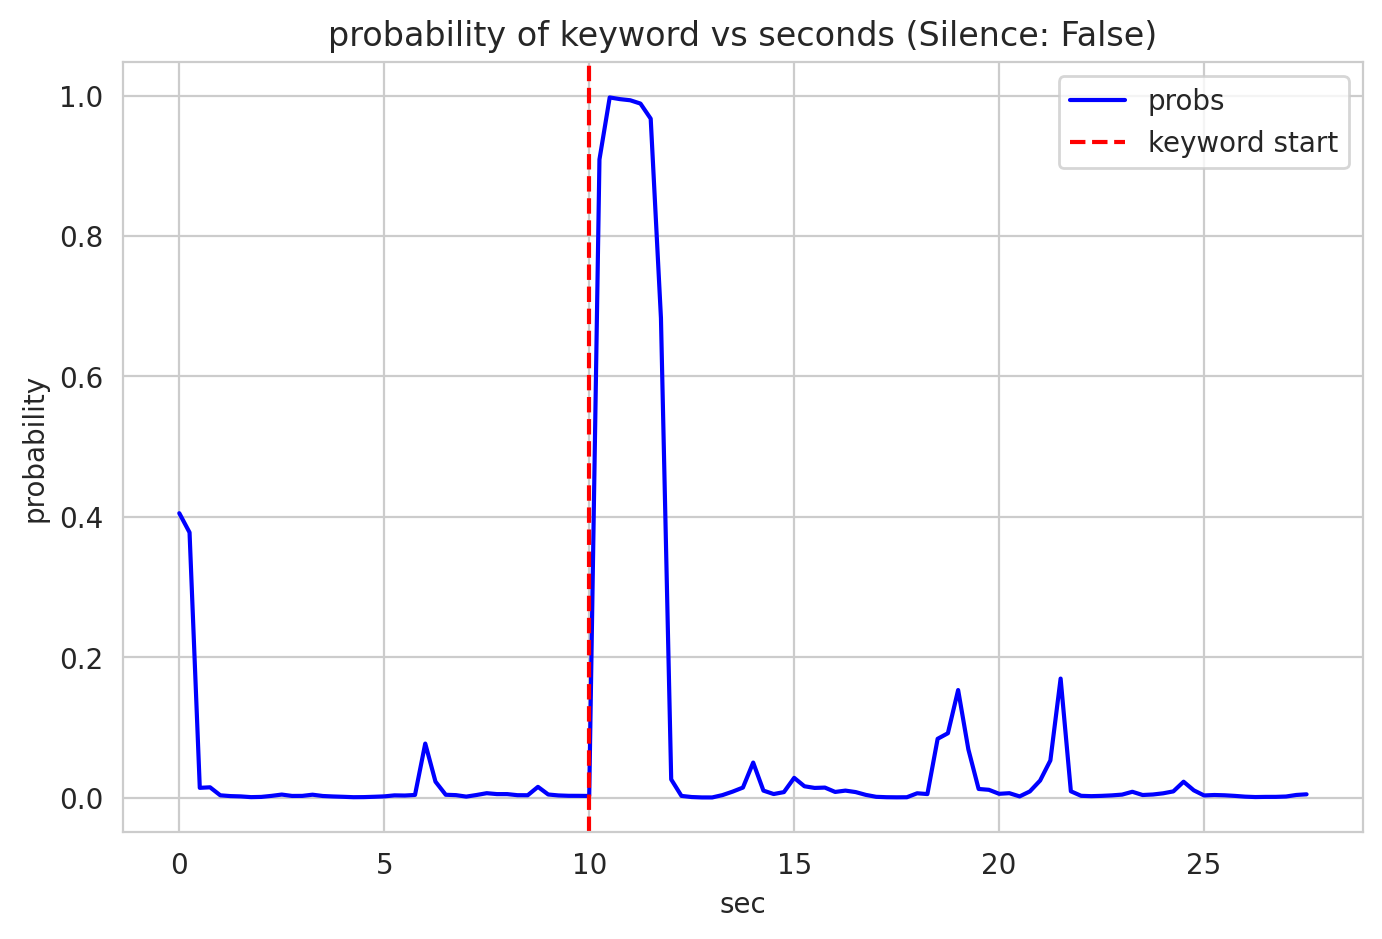

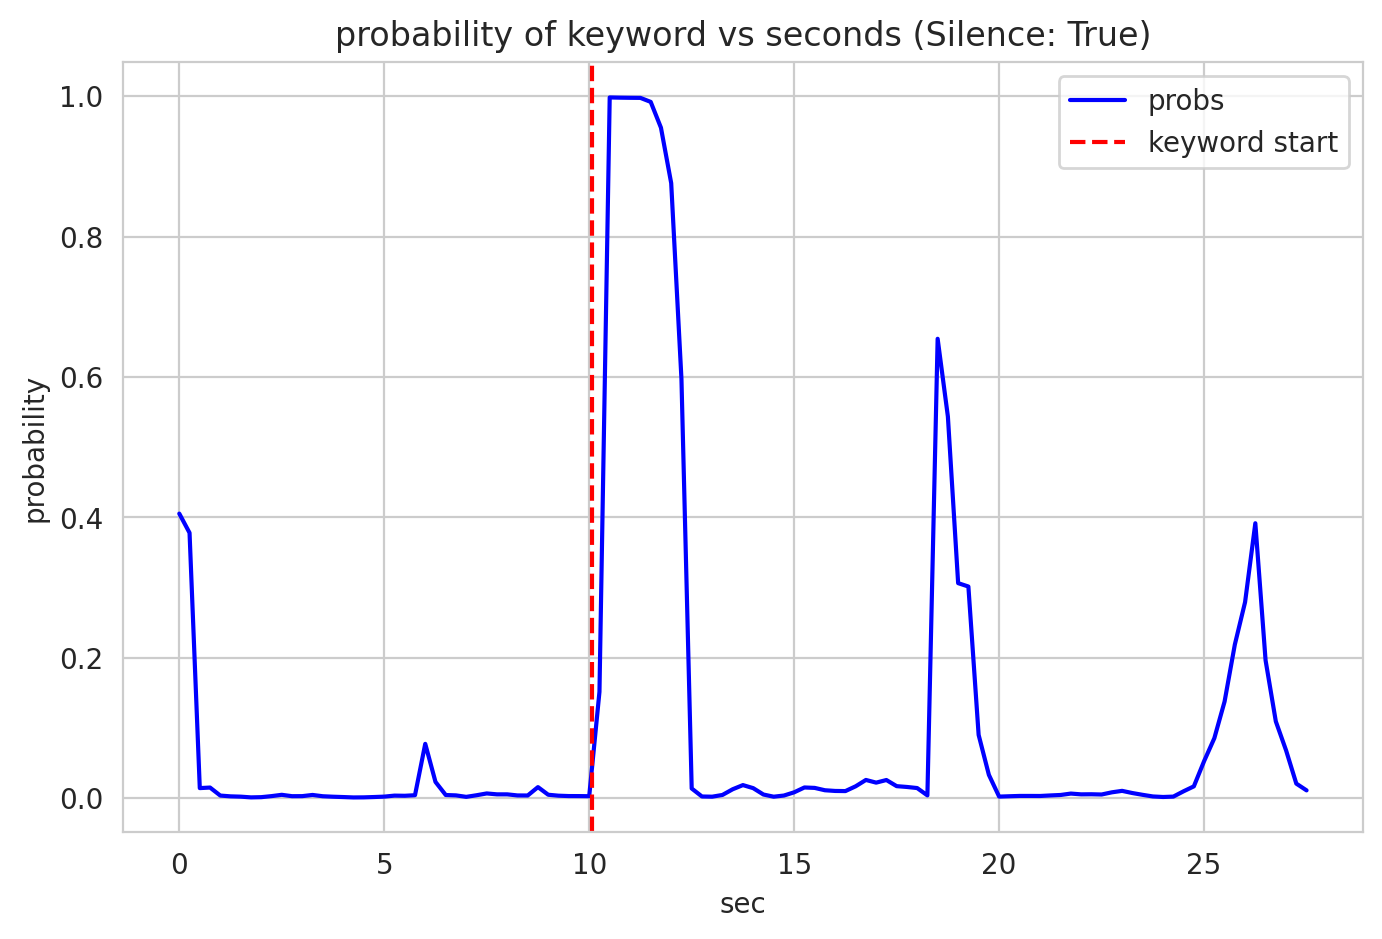

In [83]:
# wandb.init(project='KWS_SPEED_UP', name='Data_Log_Streaming')

streaming_original_model._zero_memory()
image_no_silence = plot_probs(streaming_original_model, silence=False)

streaming_original_model._zero_memory()
image_silence = plot_probs(streaming_original_model, silence=True)

# wandb.log({
#   "OrigProbabilityVsSeconds": wandb.Image(T.ToTensor()(image_no_silence)),
#   "OrigProbabilityVsSecondsSilence": wandb.Image(T.ToTensor()(image_silence)),
# })

# wandb.finish()

In [81]:
streaming_original_model._zero_memory()
torch.jit.save(torch.jit.script(streaming_original_model), 'saved/jit/original/kws.pth')

In [85]:
qat_model = get_qat_from_state_dict('saved/torch/speed_up/qat_kws.pth')
quantized_model = torch.quantization.quantize_dynamic(
    qat_model, {nn.GRU, nn.Linear}, dtype=torch.qint8
)
clear_model(quantized_model)

streaming_quantized_model = StreamingModelWithMel(quantized_model, 3)
streaming_quantized_model.eval()

torch.jit.save(torch.jit.script(streaming_quantized_model),
               'saved/jit/speed_up/super_quantized_kws.pth')

In [87]:
distil_model = torch.load('saved/torch/speed_up/pruned_conv_distil_ft.pth')
clear_model(distil_model)

module = getattr(distil_model.m.conv, "1")
setattr(module, "out_channels", int(module.out_channels)) # fix tensor in value

quantized_model = torch.quantization.quantize_dynamic(
    distil_model, {nn.GRU, nn.Linear}, dtype=torch.qint8
)

streaming_distil_model = StreamingModelWithMel(quantized_model, 1)
streaming_distil_model.eval()

torch.jit.save(torch.jit.script(streaming_distil_model),
               'saved/jit/speed_up/distil_kws_buffer_1.pth')

streaming_distil_model = StreamingModelWithMel(quantized_model, 2)
streaming_distil_model.eval()

torch.jit.save(torch.jit.script(streaming_distil_model),
               'saved/jit/speed_up/distil_kws_buffer_2.pth')

streaming_distil_model = StreamingModelWithMel(quantized_model, 3)
streaming_distil_model.eval()

torch.jit.save(torch.jit.script(streaming_distil_model),
               'saved/jit/speed_up/distil_kws_buffer_3.pth')

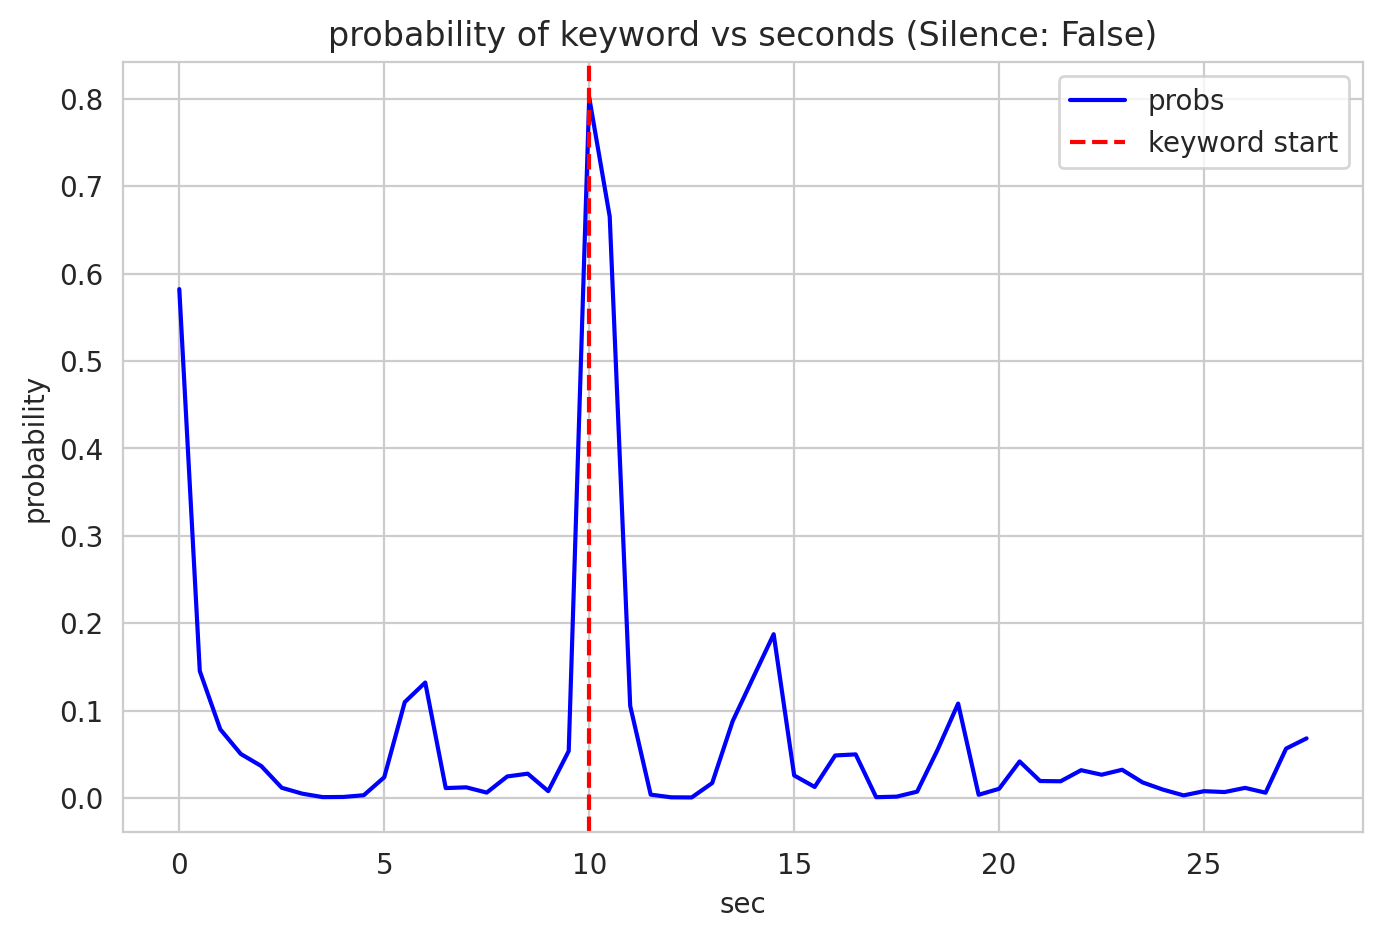

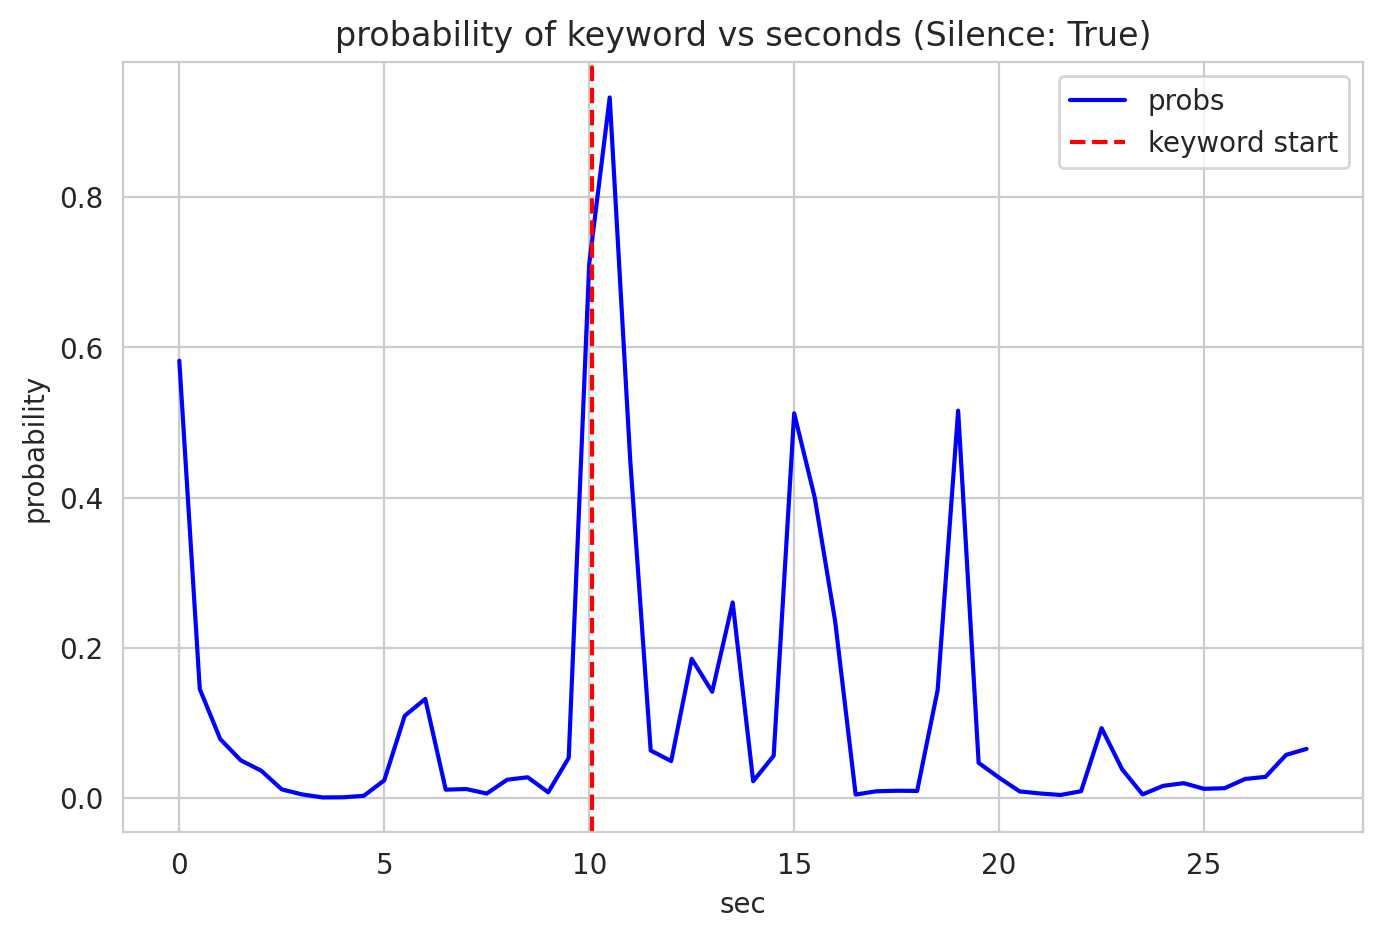

In [93]:
# wandb.init(project='KWS_SPEED_UP', name='Data_Log_Streaming')

CHUNK_SIZE = 8000

streaming_distil_model = torch.jit.load('saved/jit/speed_up/distil_kws_buffer_1.pth')
image_no_silence = plot_probs(streaming_distil_model, silence=False)

streaming_distil_model = torch.jit.load('saved/jit/speed_up/distil_kws_buffer_1.pth')
image_silence = plot_probs(streaming_distil_model, silence=True)

# wandb.log({
#   "FinalProbabilityVsSeconds": wandb.Image(T.ToTensor()(image_no_silence)),
#   "FinalProbabilityVsSecondsSilence": wandb.Image(T.ToTensor()(image_silence)),
# })

# wandb.finish()

# Model Comparison

In [94]:
def clear_model(model):
    """
    Removes extra memory usage from flops_counter
    """
    for name, param in model.named_modules():
        if name == '':
            continue
        split_name = name.split('.')
        module = model
        for elem in split_name:
            module = getattr(module, elem)
        if hasattr(module, 'total_ops'):
            delattr(module, 'total_ops')
        if hasattr(module, 'total_params'):
            delattr(module, 'total_params')

def get_qat_model(path, map_location='cpu'):
    qat_model = get_qat_from_state_dict(path)
    qat_model.m.gru.flatten_parameters()
    quantized_model = torch.quantization.quantize_dynamic(
        qat_model, {nn.GRU, nn.Linear}, dtype=torch.qint8
    )
    clear_model(quantized_model)
    return quantized_model
  
def get_final_model(path, map_location='cpu'):
    distil_model = torch.load(path,
                              map_location=map_location)
    distil_model.m.gru.flatten_parameters()
    quantized_model = torch.quantization.quantize_dynamic(
        distil_model, {nn.GRU, nn.Linear}, dtype=torch.qint8
    )
    clear_model(quantized_model)
    return quantized_model
  
def get_model(path, map_location='cpu'):
    model = torch.load(path, map_location=map_location)
    model.m.gru.flatten_parameters()
    clear_model(model)
    return model

In [95]:
config.device = 'cpu'

saved_models_code_names = [
    "V0",
    "V1",
    "V2",
    "V3",
    "V4",
    "V5",
    "V6",
]

saved_models_names = [
    "Original",
    "StructuredPruning",
    "QAT+Dynamic",
    "BaseDistillation",
    "LayerDistillation",
    "Conv+LayerDistillation",
    "Conv+LayerDistillation+FT+Dynamic"
]

saved_models_path = [
    "saved/torch/original/kws.pth",
    "saved/torch/speed_up/pruned_structured_kws.pth",
    "saved/torch/speed_up/qat_kws.pth",
    "saved/torch/speed_up/distil_kws.pth",
    "saved/torch/speed_up/layer_distil_kws2.pth",
    "saved/torch/speed_up/conv_layer_distil_kws.pth",
    "saved/torch/speed_up/pruned_conv_distil_ft.pth"
]

saved_models_load_functions = [
    get_model,
    get_model,
    get_qat_model,
    get_model,
    get_model,
    get_model,
    get_final_model,
]

colors = [
    'red',
    'blue',
    'green',
    'yellow',
    'brown',
    'purple',
    'black'
]

In [96]:
# Due to restart of the notebook and seed issues
# The comparison wont be on the original data set

set_seed(84)

def get_loader():
    indexes = torch.randperm(len(dataset))
    val_indexes = indexes[int(len(dataset) * 0.8):]

    val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

    val_set = SpeechCommandDataset(csv=val_df)

    val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                            shuffle=False, collate_fn=Collator(),
                            num_workers=2, pin_memory=True)
    return val_loader

val_loader = get_loader()

In [98]:
model_res = []
model_flops = []
model_weights = []
model_size = []
models = []

for i in range(len(saved_models_code_names)):
    code_name = saved_models_code_names[i]
    name = saved_models_names[i]
    load_func = saved_models_load_functions[i]
    load_path = saved_models_path[i]
    model = load_func(load_path, map_location='cpu')
    res = evaluation(model, val_loader, 'cpu')[0]
    size = get_size_in_megabytes(model) # do it before flops to prevent extra memory
    macs, weights = get_weights_and_flops(model)
    flops = macs / 2

    model_res.append(res)
    model_flops.append(flops)
    model_weights.append(weights)
    model_size.append(size)
    models.append(model)

102it [00:03, 30.50it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


102it [00:03, 30.44it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


102it [00:03, 28.93it/s]


[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.


102it [00:03, 29.29it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


102it [00:03, 28.10it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


102it [00:03, 28.87it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


102it [00:04, 24.94it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.


In [88]:
# Fix for quantized models

model_flops[2] = model_flops[0]
model_weights[2] = model_weights[0]

distil_model = torch.load('saved/torch/speed_up/pruned_conv_distil_ft.pth')
model_flops[-1] = get_weights_and_flops(distil_model)[0] / 2
model_weights[-1] = get_weights_and_flops(distil_model)[1]

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


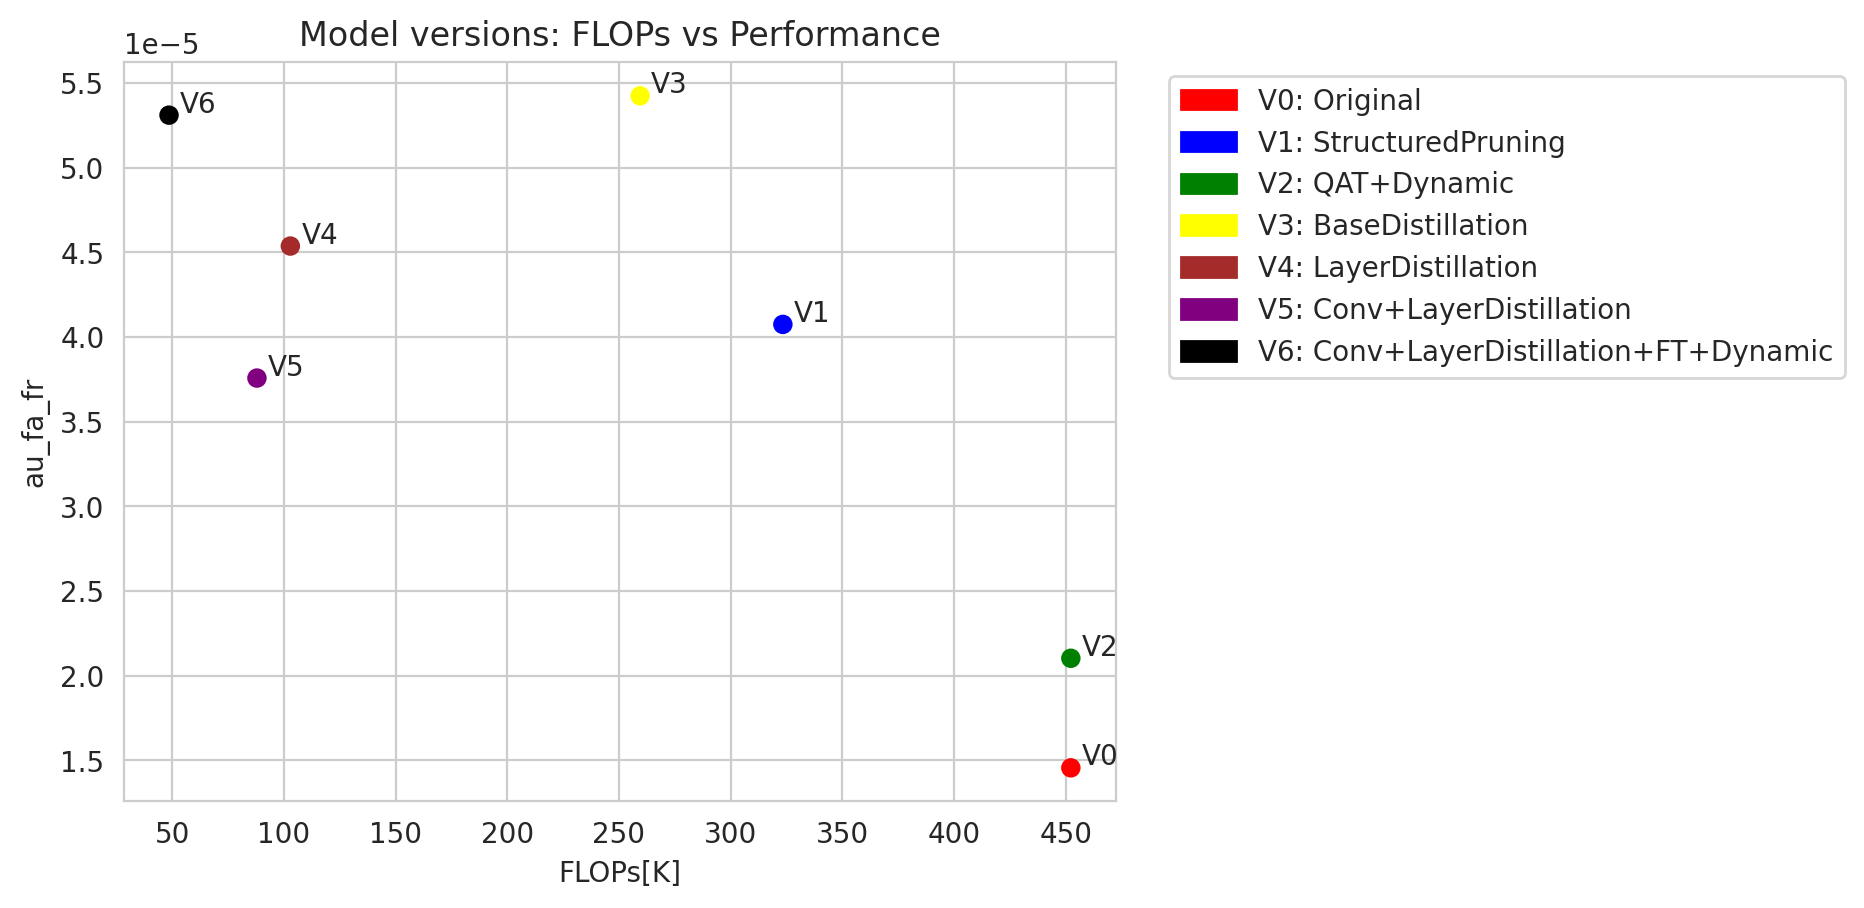

In [89]:
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot
# https://stackoverflow.com/questions/39500265/how-to-manually-create-a-legend

patches = []

plt.scatter(np.array(model_flops) / 1000, model_res, color=colors)
for i in range(len(model_res)):
    x = (np.array(model_flops) / 1000)[i]
    y = model_res[i]
    name = saved_models_code_names[i]
    real_name = saved_models_names[i]
    
    patch = plt_patch.Patch(color=colors[i], label=f'{name}: {real_name}')
    patches.append(patch)
    plt.annotate(name, (x, y), xytext=(4, 1), textcoords='offset points')

plt.legend(handles=patches, bbox_to_anchor=(1.04, 1), loc="upper left")
plt.ylabel('au_fa_fr')
plt.xlabel('FLOPs[K]')
plt.title('Model versions: FLOPs vs Performance')

buf = io.BytesIO()
plt.savefig(buf, format='png', dpi=500, bbox_inches='tight')
buf.seek(0)

flops_image = PIL.Image.open(buf)

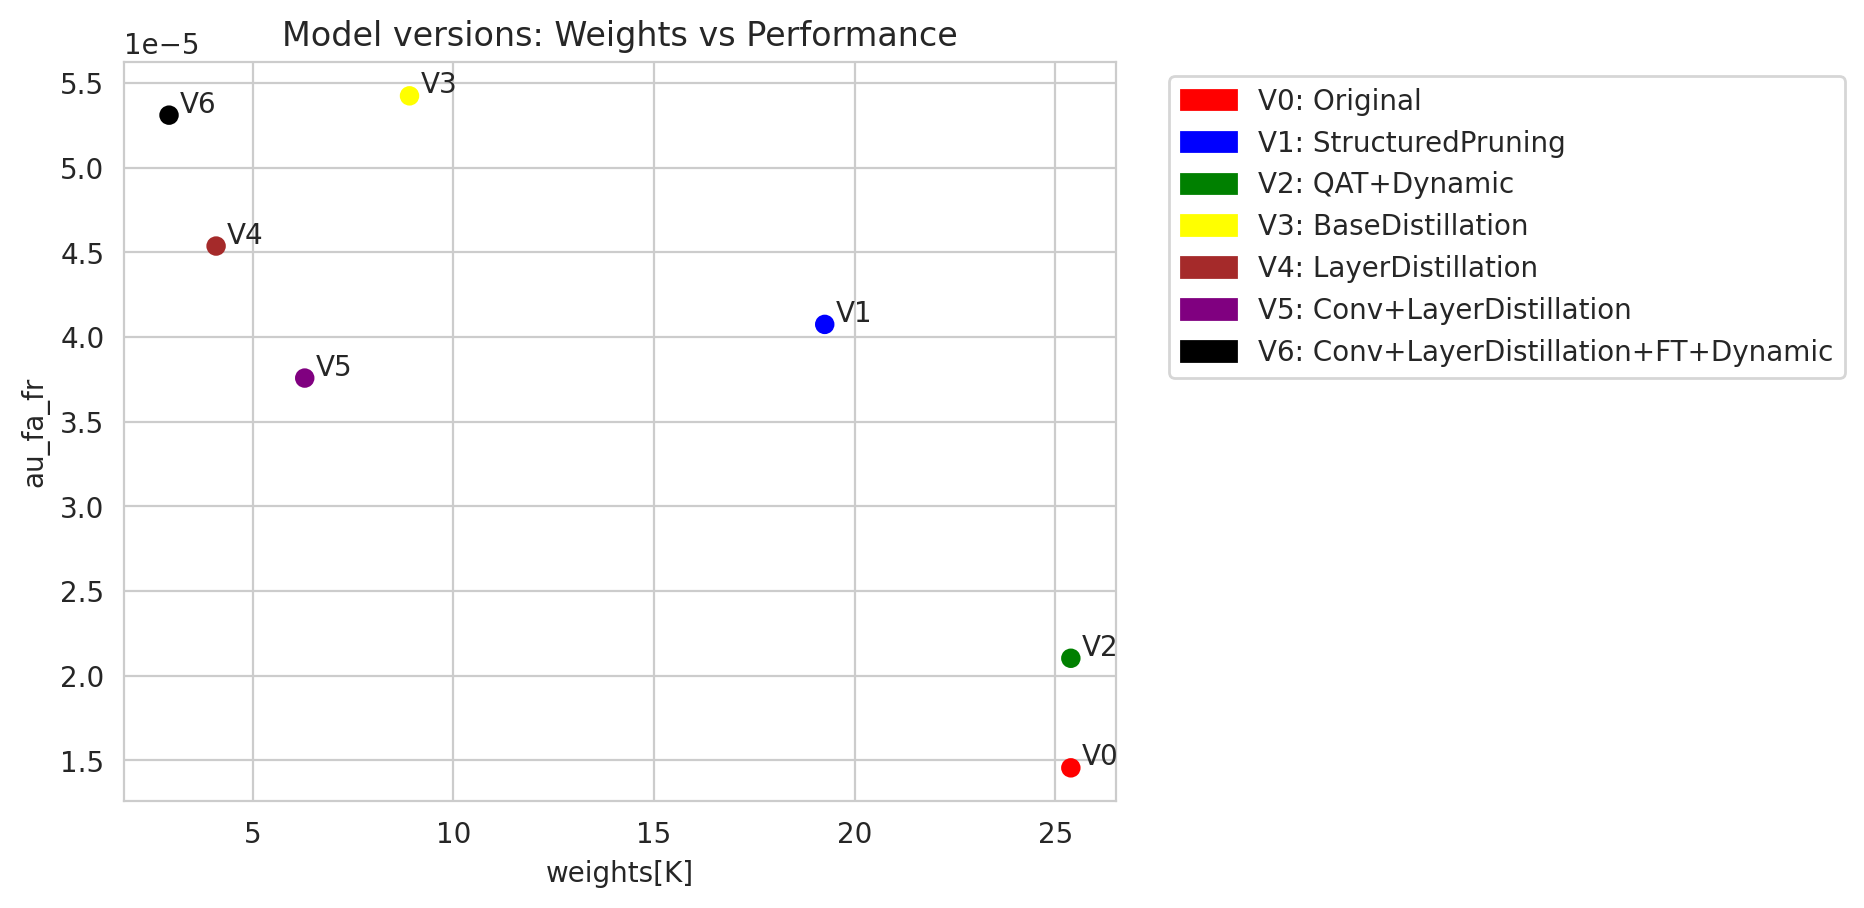

In [90]:
patches = []

plt.scatter(np.array(model_weights) / 1000, model_res, color=colors)
for i in range(len(model_res)):
    x = (np.array(model_weights) / 1000)[i]
    y = model_res[i]
    name = saved_models_code_names[i]
    real_name = saved_models_names[i]
    
    patch = plt_patch.Patch(color=colors[i], label=f'{name}: {real_name}')
    patches.append(patch)
    plt.annotate(name, (x, y), xytext=(4, 1), textcoords='offset points')

plt.legend(handles=patches, bbox_to_anchor=(1.04, 1), loc="upper left")
plt.ylabel('au_fa_fr')
plt.xlabel('weights[K]')
plt.title('Model versions: Weights vs Performance')

buf = io.BytesIO()
plt.savefig(buf, format='png', dpi=500, bbox_inches='tight')
buf.seek(0)

weights_image = PIL.Image.open(buf)

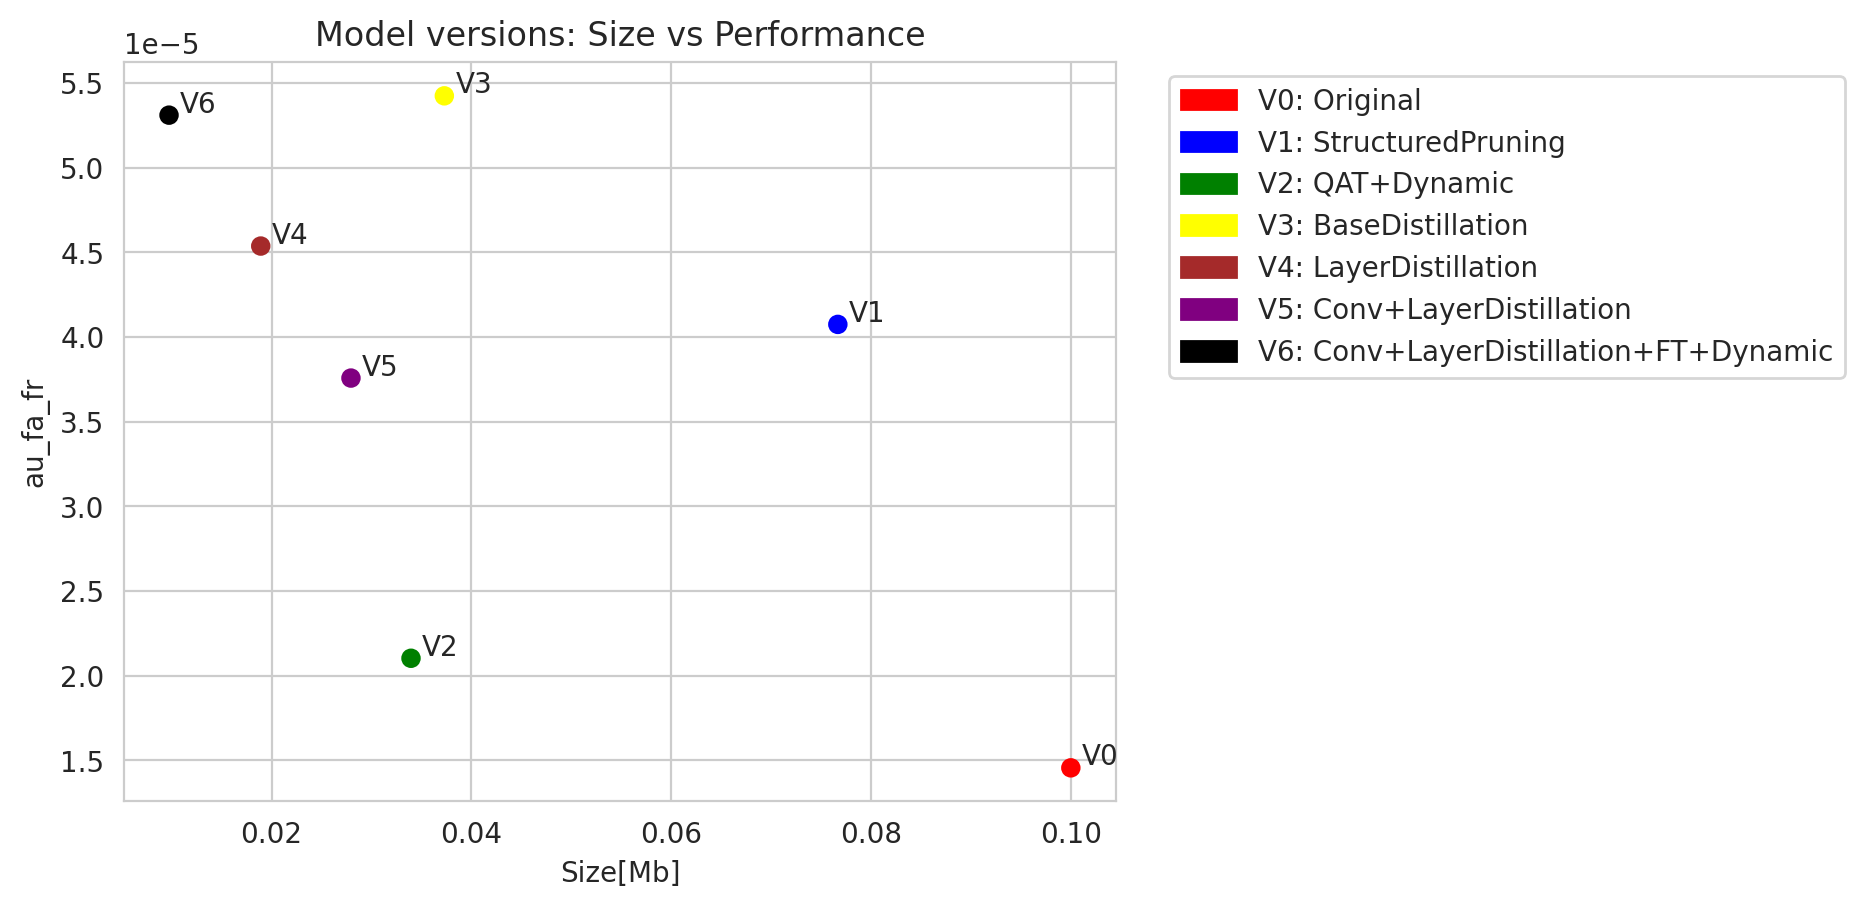

In [91]:
patches = []

plt.scatter(np.array(model_size), model_res, color=colors)
for i in range(len(model_res)):
    x = (np.array(model_size))[i]
    y = model_res[i]
    name = saved_models_code_names[i]
    real_name = saved_models_names[i]
    
    patch = plt_patch.Patch(color=colors[i], label=f'{name}: {real_name}')
    patches.append(patch)
    plt.annotate(name, (x, y), xytext=(4, 1), textcoords='offset points')

plt.legend(handles=patches, bbox_to_anchor=(1.04, 1), loc="upper left")
plt.ylabel('au_fa_fr')
plt.xlabel('Size[Mb]')
plt.title('Model versions: Size vs Performance')

buf = io.BytesIO()
plt.savefig(buf, format='png', dpi=500, bbox_inches='tight')
buf.seek(0)

size_image = PIL.Image.open(buf)

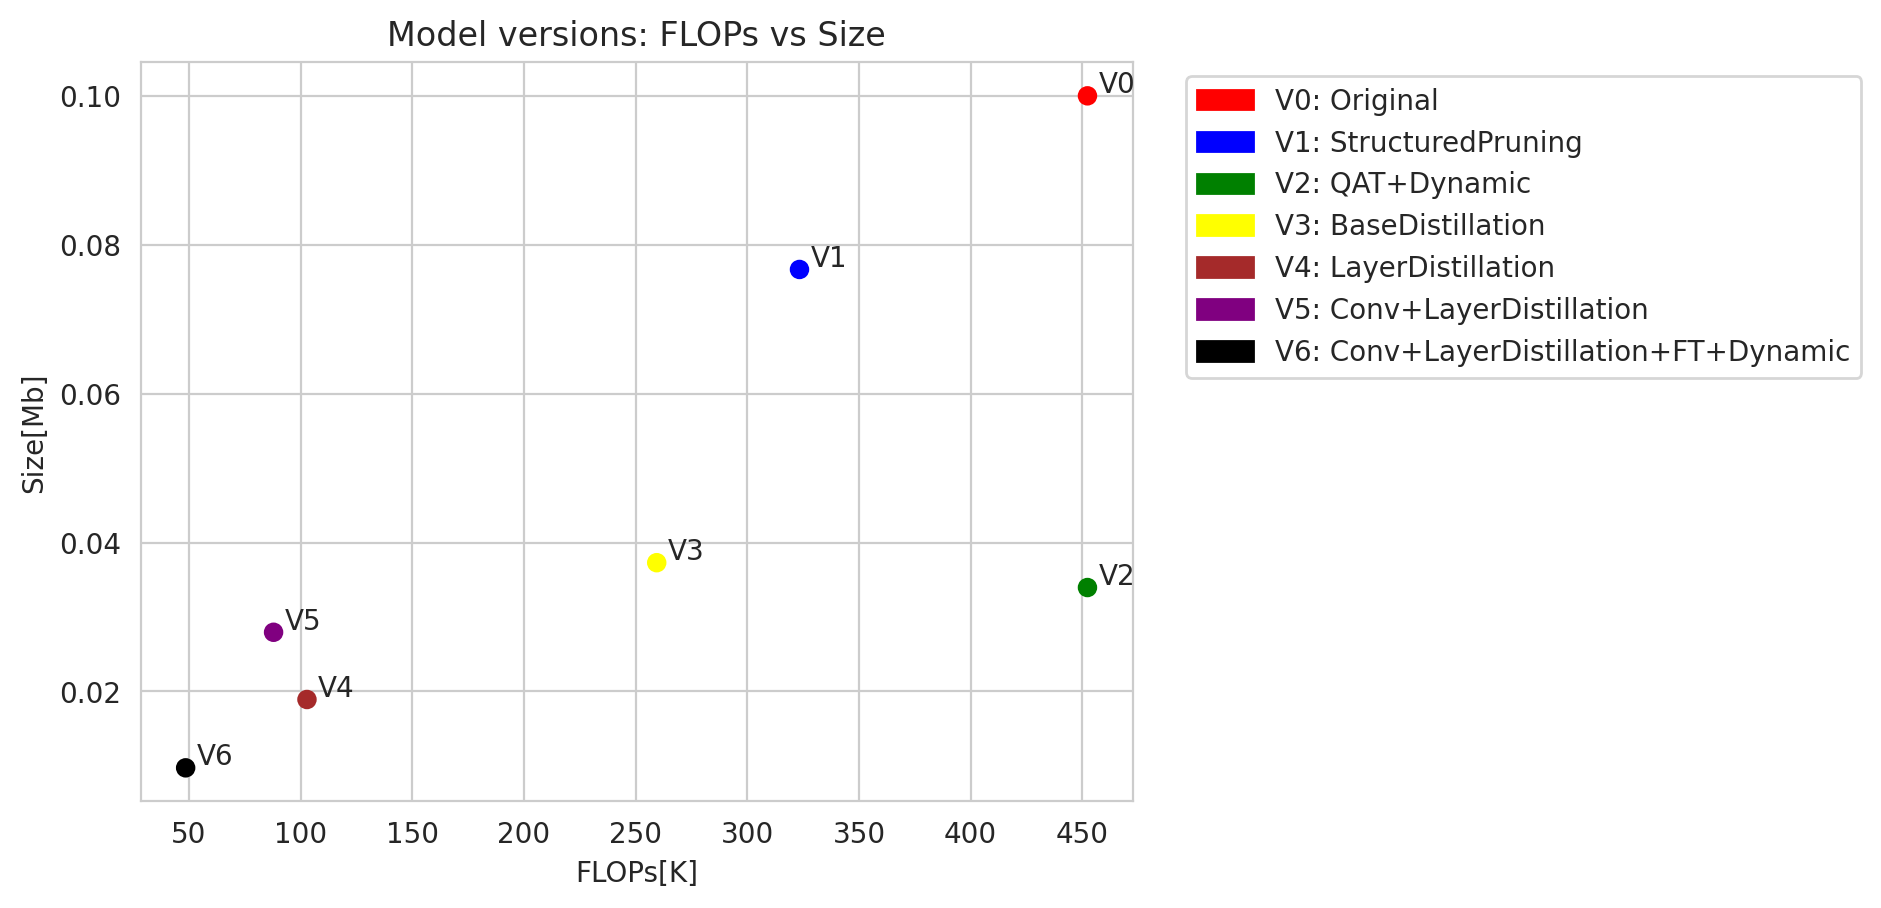

In [92]:
patches = []

plt.scatter(np.array(model_flops) / 1000, model_size, color=colors)
for i in range(len(model_res)):
    x = (np.array(model_flops) / 1000)[i]
    y = model_size[i]
    name = saved_models_code_names[i]
    real_name = saved_models_names[i]
    
    patch = plt_patch.Patch(color=colors[i], label=f'{name}: {real_name}')
    patches.append(patch)
    plt.annotate(name, (x, y), xytext=(4, 1), textcoords='offset points')

plt.legend(handles=patches, bbox_to_anchor=(1.04, 1), loc="upper left")
plt.ylabel('Size[Mb]')
plt.xlabel('FLOPs[K]')
plt.title('Model versions: FLOPs vs Size')

buf = io.BytesIO()
plt.savefig(buf, format='png', dpi=500, bbox_inches='tight')
buf.seek(0)

flops_size_image = PIL.Image.open(buf)

In [94]:
wandb.init(project='KWS_SPEED_UP', name='Data_Log_Comparison')

wandb.log({
  "FlopsVsPerformance": wandb.Image(T.ToTensor()(flops_image)),
  "WeightsVsPerformance": wandb.Image(T.ToTensor()(weights_image)),
  "SizeVsPerformance": wandb.Image(T.ToTensor()(size_image)),
  "FlopsVsSize": wandb.Image(T.ToTensor()(flops_size_image)),
})

wandb.finish()

# Conclusion

Best model is the fine-tuned by layer-wise distillation version of conv-structured and attention-structured pruned student model which is itself a result of layer-wise distillation with replacement of Conv2d to DepthWise Separable Convolution with smaller config settings

In [99]:
final_model = get_final_model(saved_models_path[-1])
distil_model = get_model(saved_models_path[-1])
original_model = get_model(saved_models_path[0])

size_orig = get_size_in_megabytes(original_model)
size_final = get_size_in_megabytes(final_model)

flops_orig = get_weights_and_flops(original_model)[0]
flops_final = get_weights_and_flops(distil_model)[0]

speed_up_rate = flops_orig / flops_final
compression_rate = size_orig / size_final

print(f'Speed up rate: {speed_up_rate}')
print(f'Compression rate: {compression_rate}')
print(f'Quality estimation: {(speed_up_rate + compression_rate) / 20}')

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Speed up rate: 9.314812335890439
Compression rate: 10.26162278555349
Quality estimation: 0.9788217560721965


In [100]:
7 * (speed_up_rate + compression_rate) / 20

6.851752292505376

In [101]:
7 * (9.315 + 10) / 20

6.760249999999999